# Big Table of Contents

* [Homology Scores](#Homology-Scores)
* [New Simulations: Single Pattern Occurrence in Text](#New-Simulations-\--Single-Pattern-Occurrence-in-Text)
* [Precision and Recall Evaluation of minimap2](#Precision-and-Recall-Evaluation-of-minimap2)
* [Simulation Run 3: FindThoms (C++) vs. minimap2 vs. Winnowmap2](#Simulation-Run-3:-FindThoms-(C++)-vs.-minimap2-vs.-Winnowmap2)
* [Benchmark on Real Data](#Benchmark-on-Real-Data)
* [Expectation Value Estimation](#Expectation-Value-Estimation)
* [Testing](#Testing)

In [ ]:
from glob import glob

scores = {"intersec": {}, "algnWoutOffs": {}}

#Iterate over simulation results
for m in scores.keys():
    for f in glob(f"../simulations/scores_mes{m}_s20620220951_n100_l10008_m*.txt"):
        #Parse mutation rate from file name
        mRate = float(f.split("_m")[2].split("_i")[0])
        #Initialize a score list for each mutation rate
        scores[m][mRate] = []

        for l in open(f, 'r'):
            scores[m][mRate].append(int(l))

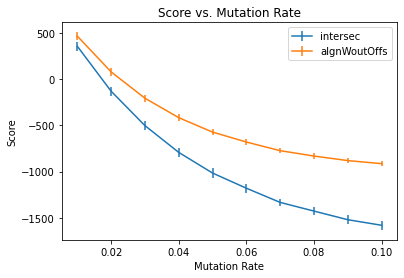

In [17]:
from matplotlib import pyplot as plt
from numpy import mean, std

rateRange = sorted(scores["algnWoutOffs"].keys())

for m in scores.keys():
    plt.errorbar(rateRange, [mean(scores[m][r]) for r in rateRange], yerr=[std(scores[m][r]) for r in rateRange], \
                label=m)
    
plt.title("Score vs. Mutation Rate")
plt.xlabel("Mutation Rate")
plt.ylabel("Score")
plt.legend()
plt.show()

# Homology Scores
[Back to Big Table of Contents](#Big-Table-of-Contents)

## Contents 1
* [Find Threshold Score to Find All Homologies](#Find-Threshold-Score-to-Find-All-Homologies)
* [Duplication Aware $t$-homology Detection](#Duplication-Aware-\$t\$\-homology-Detection)

In [154]:
#Mapping between a nucleotide character and its bitwise representation
NT_IN_BITS = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

#This function calculates the hash of a bitwise k-mer representation. The function is influenced by the code of "The minimizer Jaccard estimator is 
#biased and inconsistent." from Belbasi et al. (function "minimap2_hash(seed,v,mask)" in file "minimap2_hash_uncompiled.py").
def getHash(kmer, mask):
    u = kmer & mask
    u = ((~u) + (u << 21)) & mask # u = (u<<21)-(u+1) = 77594587*u-1
    u = u ^ (u >> 24)
    u = ((u + (u << 3)) + (u << 8)) & mask # u *= 265
    u = u ^ (u >> 14)
    u = ((u + (u << 2)) + (u << 4)) & mask # u *= 21
    u = u ^ (u >> 28)
    u = (u + (u << 31)) & mask # u *= 2147483649

    return u

#This function calculates the sketch of a sequence. It is influenced by the code of "The minimizer Jaccard estimator is biased and inconsistent."
#from Belbasi et al. (function "hash_sequence(seq,kmerSize,hashFunc,canonical=False)" in file "jaccard_correction_test.py").
def calcSketch(seq, k, thres):
    sketch = []

    #Calculate mask
    mask = (4 ** k) - 1

    #Iterate of all k-mers in sequence
    for i in range(len(seq) - k + 1):
        kmerBits = 0

        #Get bit representation of k-mer
        for c in seq[i:i+k]:
            kmerBits = (kmerBits << 2) + NT_IN_BITS[c]

        #Calculate hash
        kmerHash = getHash(kmerBits, mask)

        #Add hash to sketch if it is small enough
        if kmerHash <= thres:
            sketch.append((i, kmerHash))

    return sketch

In [145]:
from glob import glob
from math import floor

#K-mer length
K = 9

def getTextSketches(filesPath):
    #Dictionary to store sketches of all texts
    textSketches = {}
    
    #Calculate sketches of sequences
    for f in glob(filesPath):
        #Get mutation rate
        mRate = float(f.split("_m")[1].split("_i")[0])
        #Initialize new list
        textSketches[mRate] = []
        #Calculate hash threshold
        thres = floor(((4 ** K) - 1) * 0.1)
    
        for l in open(f, 'r'):
            textSketches[mRate].append(calcSketch(l.strip().split(' ')[1], K, thres))
        
    return textSketches
        
textSketches = getTextSketches("../simulations/searchPairs_gn100_rn400_gl1000_rl500_o3_m0*")

In [132]:
##Load found t-homologies##

#A dictionary for all scores
scores = {}
#A dictionary to store the number ob found t-homologies per pair
homsPerPair = {}
#A dictionary to store the percentage of coverage of real homologies by t-homologies
percCovs = {}
#A dictionary to store start end stop positions of all t-homologies
coords = {}

for f in glob("../simulations/homologies_gn100_rn400_gl1000_rl500_o3_m0*"):
    #Get mutation rate
    mRate = float(f.split("_m")[1].split("_i")[0])
    lastPairID = 1
    nbHoms = 0
    
    #Initialize new lists
    for d in scores, homsPerPair, percCovs, coords:
        d[mRate] = []
    
    for l in open(f, 'r'):
        l.strip()
        
        if l.startswith("Pair"):
            pairID = int(l.split(' ')[1])
            coords[mRate].append([])
            continue
            
        if l.startswith('['):
            #Get score
            scores[mRate].append(int(l.split(' ')[1]))
            #Get start position in sequence
            start = textSketches[mRate][pairID - 1][int(l.split('[')[1].split(',')[0])][0]
            #Get end position in sequence
            end = textSketches[mRate][pairID - 1][int(l.split(',')[1].split(']')[0])][0]
            #Save start and end coordinates
            coords[mRate][-1].append((start, end))
            #Add sequence coverage
            percCovs[mRate].append((end - start) / 5000.)
            
            #Check if we are dealing with a new pair
            if lastPairID != pairID:
                homsPerPair[mRate].append(nbHoms)
                nbHoms = 0
                lastPairID = pairID
                
            #Count homologies for this pair
            nbHoms += 1
    
    homsPerPair[mRate].append(nbHoms)
    
    #Testing
    #print("len(coords[mRate])", len(coords[mRate]))

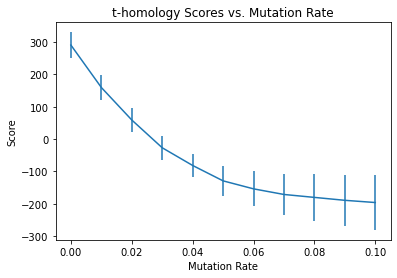

In [48]:
from matplotlib import pyplot as plt
from numpy import mean, std

rates = sorted(scores.keys())
plt.errorbar(rates, [mean(scores[r]) for r in rates], yerr=[std(scores[r]) for r in rates])    
plt.title("t-homology Scores vs. Mutation Rate")
plt.xlabel("Mutation Rate")
plt.ylabel("Score")
plt.show()

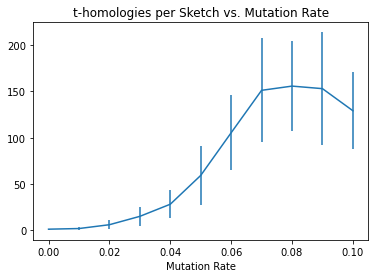

In [49]:
rates = sorted(homsPerPair.keys())
plt.errorbar(rates, [mean(homsPerPair[r]) for r in rates], yerr=[std(homsPerPair[r]) for r in rates])    
plt.title("t-homologies per Sketch vs. Mutation Rate")
plt.xlabel("Mutation Rate")
plt.show()

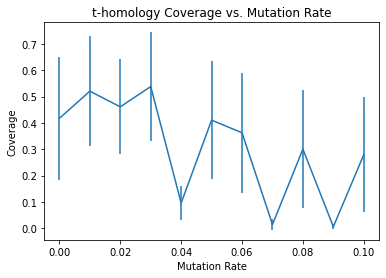

In [133]:
rates = sorted(percCovs.keys())
plt.errorbar(rates, [mean(percCovs[r]) for r in rates], yerr=[std(percCovs[r]) for r in rates])    
plt.title("t-homology Coverage vs. Mutation Rate")
plt.xlabel("Mutation Rate")
plt.ylabel("Coverage")
plt.show()

## Find Threshold Score to Find All Homologies
[Back to Contents](#Contents-1)

In [134]:
#Map scores to coordinates
results = {}

for m in scores.keys():
    results[m] = []
    i = 0
    
    for p in coords[m]:
        results[m].append([])
        
        for c in p:
            results[m][-1].append((scores[m][i], c[0], c[1]))
            i += 1

In [151]:
#Load pattern sketches
def loadPatternSketches(filesPath):
    patternSketches = {}

    for f in glob(filesPath):
        #Get mutation rate
        mRate = float(f.split("_m")[1].split("_i")[0])
        #Initialize new list
        patternSketches[mRate] = []
        #Calculate hash threshold
        thres = floor(((4 ** K) - 1) * 0.1)
    
        for l in open(f, 'r'):
            patternSketches[mRate].append(calcSketch(l.strip().split(' ')[0], K, thres))
        
    return patternSketches

patternSketches = loadPatternSketches("../simulations/searchPairs_gn100_rn400_gl1000_rl500_o3_m0*")

In [153]:
#Calculate initial homology intervals
def calcHomIntervals(textSketches, patternSketches, iniHomStart, iniHomEnd, homSteps):
    homInts = {}

    for m in textSketches.keys():
        homInts[m] = []
    
        for i in range(len(textSketches[m])):
            patternHashes = [p[1] for p in patternSketches[m][i]]
            homInts[m].append([])
            nextHomStart = iniHomStart
            nextHomEnd = iniHomEnd
        
            #Testing
            #first = True
        
            for h in textSketches[m][i]:
                if nextHomStart < nextHomEnd:
                    if h[1] in patternHashes and h[0] >= nextHomStart and h[0] <= nextHomEnd:
                    
                        #Testing
                        #if m == 0.0 and i == 0 and first:
                        #    print(h[1])
                        #    print("At position", h[0])
                        #    first = False
                        
                        homInts[m][i].append([h[0], h[0]])
                        nextHomStart += homSteps
                else:
                    if h[1] in patternHashes and h[0] <= nextHomEnd:
                        homInts[m][i][-1][1] = h[0]
                
                    if h[0] > nextHomEnd:
                        nextHomEnd += homSteps
                    
    return homInts    

homInts = calcHomIntervals(textSketches, patternSketches, 500, 1500, 1500)

In [126]:
#Testing
firstPairPattern = [p[1] for p in patternSketches[0][0]]
patternFromScript = [6819, 4825, 2786, 17024, 11466, 9845, 14117, 16318, 15893, 26111, 15483, 23409, 22874, 22613, 16477, 14592, 10367, 5826, 22632, 11640, 24216, 15968, 1870, 13045, 22837, 3813, 15651, 1424, 16826, 21844, 22333, 4823, 16707, 19329, 25866, 20378, 8250, 17955, 19157, 12068, 7770, 15692, 3559, 25420, 22007, 8527, 202, 12274, 22915, 4289, 16148, 21313, 7970, 1126, 9397, 13802, 18349, 23990, 22671, 7396, 14256, 16772, 23997, 2904, 16824, 13492, 9498, 13999, 3964, 16617, 15133, 16170, 20002, 2809, 2582, 10391, 25520, 8973, 10031, 19638, 20844, 14615, 10164, 3754]

if firstPairPattern == patternFromScript:
    print("Patterns are equal")
else:
    print("Patterns are NOT equal")
    
patternFromScript.index(20729)

Patterns are equal


ValueError: 20729 is not in list

In [210]:
from math import inf

def findMinScores(results, homInts):
    #Find threshold score
    minScores = {}

    for m in results.keys():
        minScore = inf
    
        for i in range(len(results[m])):
            pairResults = sorted(results[m][i], key=lambda r: r[0], reverse=True)
            intervals = list(homInts[m][i])
        
            while pairResults and intervals:
                res = pairResults.pop(0)
                newIntervals = []
            
                for intv in intervals:
                    #t-homology overlaps end of interval
                    if res[1] >= intv[0] and res[1] <= intv[1]:
                        #t-homology does not overlap interval's start
                        if res[1] - intv[0] > 0:
                            newIntervals.append([intv[0], res[1] - 1])
                    #t-homology overlaps start of interval
                    if res[2] >= intv[0] and res[2] < intv[1]:
                        newIntervals.append([res[2] + 1, intv[1]])
                    #t-homology starts behind interval
                    if res[1] > intv[1]:
                        newIntervals.append(intv)
                    #t-homology ends in front of interval
                    if res[2] < intv[0]:
                        newIntervals.append(intv)
                      
                #Testing
                #print("res:", res)
                #print("intervals:", intervals)
                #print("newIntervals:", newIntervals)
            
                intervals = newIntervals
            
                if minScore > res[0]:
                    minScore = res[0]
                
        minScores[m] = minScore
        
    return minScores

In [149]:
minScores = findMinScores(results, homInts)

minScores

{0.06: -123,
 0.01: -95,
 0.09: -387,
 0.07: -390,
 0.05: -122,
 0.0: 158,
 0.08: -142,
 0.1: -162,
 0.03: -56,
 0.04: -352,
 0.02: -276}

In [136]:
for m in results.keys():
    print(m, min([r[0] for p in results[m] for r in p]))

0.06 -345
0.01 -312
0.09 -387
0.07 -390
0.05 -317
0.0 -139
0.08 -416
0.1 -450
0.03 -141
0.04 -362
0.02 -361


In [428]:
#Load non-unit score results

def loadHomologies(filesPath, textSketches, normScrs):
    res = {}

    for f in glob(filesPath):
        #Get mutation rate
        mRate = float(f.split("_m")[1].split("_i")[0])
        lastPairID = 1
        patternPrinted = False
        res[mRate] = []
    
        for l in open(f, 'r'):
            l.strip()
        
            if l.startswith("Pair"):
                pairID = int(l.split(' ')[1])
                res[mRate].append([])
                continue
                
            if l.startswith("Pattern"):
                patternLen = len(l.split(','))
                patternPrinted = True
            
            if l.startswith('['):
                #Get start position in sequence
                start = textSketches[mRate][pairID - 1][int(l.split('[')[1].split(',')[0])][0]
                #Get end position in sequence
                end = textSketches[mRate][pairID - 1][int(l.split(',')[1].split(']')[0])][0]
                score = int(l.split(' ')[1])
                
            if l.startswith("maxNbSketches(pattern,text):"):
                if normScrs:
                    if not patternPrinted:
                        score /= float(l.split("): ")[1])
                    else:    
                        substringLen = int(l.split(',')[1].split(']')[0]) - int(l.split(',')[1].split(']')[0]) + 1
                        score /= max(patternLen, substringLen)
                    
                #Save score, start and end coordinates
                res[mRate][-1].append((score, start, end))
            
    return res

In [ ]:
nonUnitRes = loadHomologies("../simulations/homologies_gn100_rn400_gl1000_rl500_o3_m0*_c1_u3.txt", textSketches)
print(nonUnitRes[0])

In [131]:
nonUnitMinScores = findMinScores(nonUnitRes, homInts)

nonUnitMinScores

{0.06: -360,
 0.05: -382,
 0.09: -387,
 0.08: -381,
 0.01: -95,
 0.1: -373,
 0.03: -315,
 0.07: -390,
 0.0: 158,
 0.02: -276,
 0.04: -352}

In [102]:
for m in nonUnitRes.keys():
    print(m, min([r[0] for p in nonUnitRes[m] for r in p]))

0.06 -360
0.05 -382
0.09 -387
0.08 -381
0.01 -312
0.1 -373
0.03 -382
0.07 -390
0.0 -139
0.02 -361
0.04 -362


In [180]:
#Load nucmer results
nucmerResDef = loadNucmerRes("../simulations/nucmerAlignments_gn100_rn400_gl1000_rl500_o3_m0*.coords")

{0.05: [[[-inf, 501, 1495], [-inf, 2009, 2991], [-inf, 3501, 4496]],
  [[-inf, 505, 1495], [-inf, 2002, 2987], [-inf, 3501, 4491]],
  [[-inf, 501, 1496], [-inf, 2004, 2990], [-inf, 3501, 4503]],
  [[-inf, 501, 1491], [-inf, 2001, 2997], [-inf, 3501, 4482]],
  [[-inf, 511, 1489], [-inf, 2010, 2995], [-inf, 3509, 4492]],
  [[-inf, 503, 1484], [-inf, 2005, 3000], [-inf, 3521, 4488]],
  [[-inf, 504, 1498], [-inf, 2001, 2988], [-inf, 3501, 4488]],
  [[-inf, 2001, 2997]],
  [[-inf, 505, 1477], [-inf, 2001, 2995], [-inf, 3501, 4499]],
  [[-inf, 501, 1484], [-inf, 2001, 2985]],
  [[-inf, 504, 1496], [-inf, 2001, 2986], [-inf, 3501, 4495]],
  [[-inf, 501, 1492], [-inf, 2001, 2991], [-inf, 3505, 4500]],
  [[-inf, 2001, 2988], [-inf, 3514, 4493]],
  [[-inf, 2001, 2997], [-inf, 3501, 4495]],
  [[-inf, 504, 1496], [-inf, 2001, 2999], [-inf, 3501, 4494]],
  [[-inf, 501, 1492], [-inf, 3501, 4499]],
  [[-inf, 501, 1485], [-inf, 2001, 2993]],
  [[-inf, 513, 1499], [-inf, 3501, 4492]],
  [[-inf, 506, 14

In [183]:
#Load maxmatch nucmer results
nucmerResMaxmatch = loadNucmerRes("../simulations/nucmerAlignments_gn100_rn400_gl1000_rl500_o3_m0*_maxmatch_p*" + \
                                  ".coords")

{0.1: [[],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [[-inf, 723, 1474]],
  [],
  [],
  [],
  [],
  [],
  [],
  [[-inf, 501, 1388]],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  []],
 0.05: [[[-inf, 501, 1495], [-inf, 2009, 2991], [-inf, 3501, 4496]],
  [[-inf, 505, 1495], [-inf, 2002, 2987], [-inf, 3501, 4491]],
  [[-inf, 501, 1496], [-inf, 2004, 2990], [-inf, 3501, 4503]],
  [[-inf, 501, 1491], [-inf, 2001, 2997], [-inf, 3501, 4482]],
  [[-inf, 511, 1489], [-inf, 2010, 2995], [-inf, 3509, 4492]],
  [[-inf, 503, 1484], [-inf, 2005, 3000

In [193]:
#How many nucmer results do we find per search pair?
nucmerRes = [nucmerResDef, nucmerResMaxmatch]
resDesc = ["Nucmer Default:", "Nucmer --maxmatch:"]

for i in range(len(nucmerRes)):
    print(resDesc[i])
    
    for m in sorted(nucmerRes[i].keys()):
        nbResPerPair = [len(p) for p in nucmerRes[i][m]]

        print("Mut. Rate:", m, "Min:", min(nbResPerPair), "Max:", max(nbResPerPair), "Avg.:", mean(nbResPerPair), \
          "Std.:", std(nbResPerPair))

Nucmer Default:
Mut. Rate: 0.0 Min: 0 Max: 0 Avg.: 0.0 Std.: 0.0
Mut. Rate: 0.01 Min: 3 Max: 3 Avg.: 3.0 Std.: 0.0
Mut. Rate: 0.02 Min: 3 Max: 3 Avg.: 3.0 Std.: 0.0
Mut. Rate: 0.03 Min: 2 Max: 3 Avg.: 2.99 Std.: 0.09949874371066199
Mut. Rate: 0.04 Min: 2 Max: 3 Avg.: 2.84 Std.: 0.36660605559646725
Mut. Rate: 0.05 Min: 0 Max: 3 Avg.: 2.36 Std.: 0.6711184694225006
Mut. Rate: 0.06 Min: 0 Max: 3 Avg.: 1.28 Std.: 0.8494704232638121
Mut. Rate: 0.07 Min: 0 Max: 3 Avg.: 0.48 Std.: 0.6554387843269577
Mut. Rate: 0.08 Min: 0 Max: 2 Avg.: 0.22 Std.: 0.4377213725647858
Mut. Rate: 0.09 Min: 0 Max: 1 Avg.: 0.03 Std.: 0.1705872210923198
Mut. Rate: 0.1 Min: 0 Max: 1 Avg.: 0.02 Std.: 0.13999999999999999
Nucmer --maxmatch:
Mut. Rate: 0.0 Min: 3 Max: 3 Avg.: 3.0 Std.: 0.0
Mut. Rate: 0.01 Min: 3 Max: 3 Avg.: 3.0 Std.: 0.0
Mut. Rate: 0.02 Min: 3 Max: 3 Avg.: 3.0 Std.: 0.0
Mut. Rate: 0.03 Min: 3 Max: 3 Avg.: 3.0 Std.: 0.0
Mut. Rate: 0.04 Min: 2 Max: 3 Avg.: 2.93 Std.: 0.2551470164434615
Mut. Rate: 0.05 Min: 

Mutation rate: 0.0


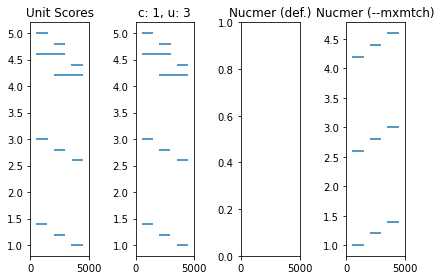

Mutation rate: 0.01


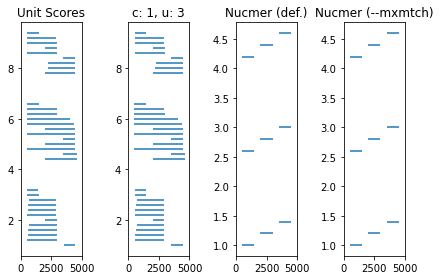

Mutation rate: 0.02


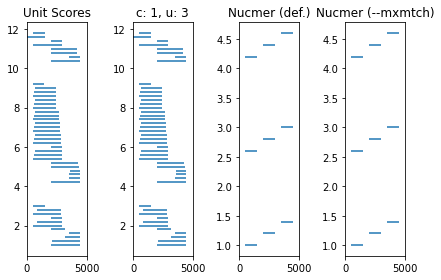

Mutation rate: 0.03


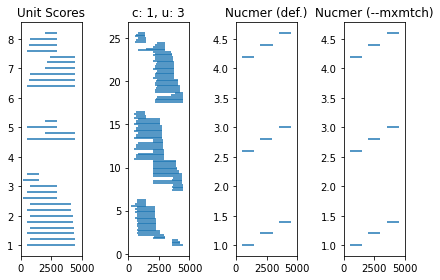

Mutation rate: 0.04


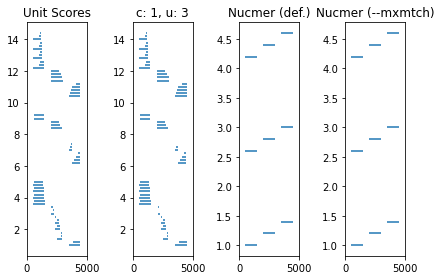

Mutation rate: 0.05


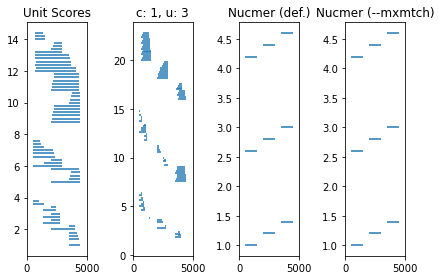

Mutation rate: 0.06


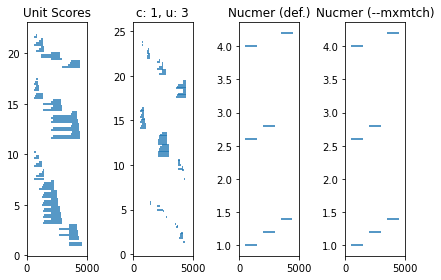

Mutation rate: 0.07


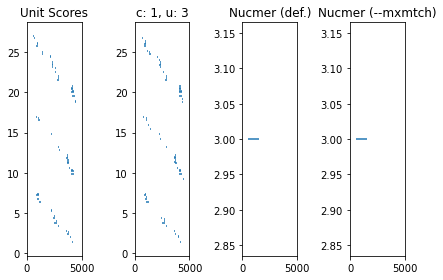

Mutation rate: 0.08


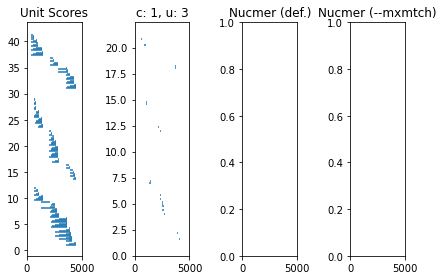

Mutation rate: 0.09


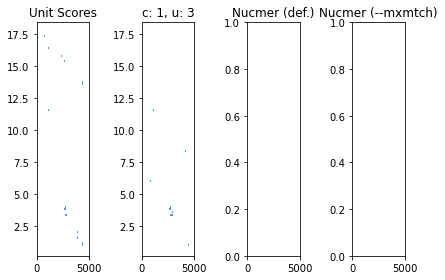

Mutation rate: 0.1


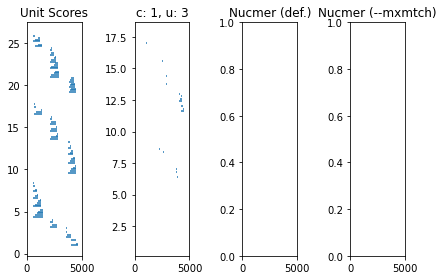

In [186]:
mRates = sorted(results.keys())
allRes = [results, nonUnitRes, nucmerResDef, nucmerResMaxmatch]
allMinScores = [minScores, nonUnitMinScores]
titles = ["Unit Scores", "c: 1, u: 3", "Nucmer (def.)", "Nucmer (--mxmtch)"]

for m in mRates:
    print("Mutation rate:", m)
    
    fig, axes = plt.subplots(1, len(allRes))
          
    for i in range(len(allRes)):
        maxY = 1.
        padding = 0.2
          
        for ps in allRes[i][m][:3]:
            toPlot = [p for p in ps if i > 1 or p[0] >= allMinScores[i][m]]
            axes[i].hlines([maxY + j * padding for j in range(len(toPlot))], [t[1] for t in toPlot], [t[2] for t \
                                                                                                      in toPlot])
            maxY += 1. + padding * len(toPlot)
        
        axes[i].set_xlim([0, 5000])
        axes[i].set_title(titles[i])
        
    plt.tight_layout()
    plt.show()

## Duplication Aware $t$-homology Detection
[Back to Contents](#Contents-1)

Mutation rate: 0.0


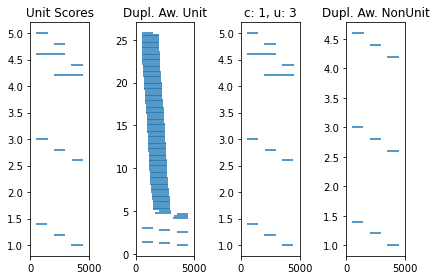

Mutation rate: 0.01


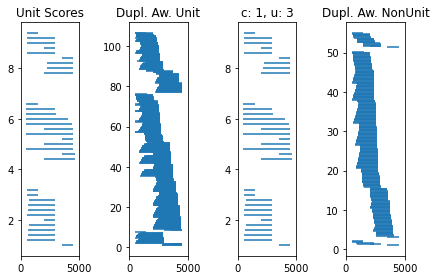

Mutation rate: 0.02


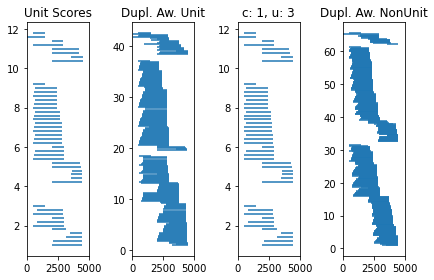

Mutation rate: 0.03


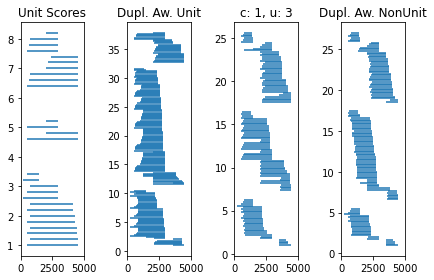

Mutation rate: 0.04


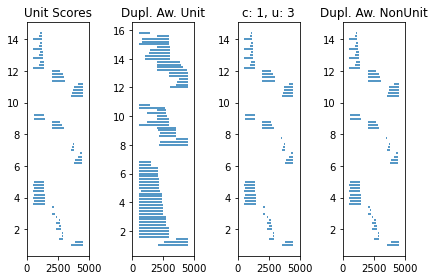

Mutation rate: 0.05


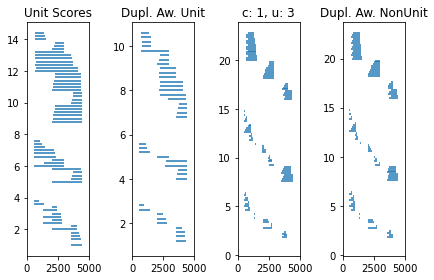

Mutation rate: 0.06


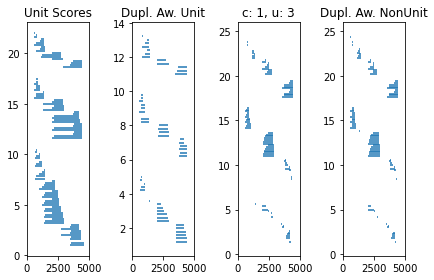

Mutation rate: 0.07


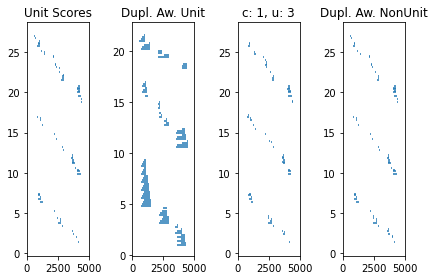

Mutation rate: 0.08


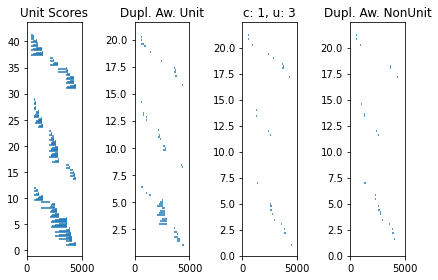

Mutation rate: 0.09


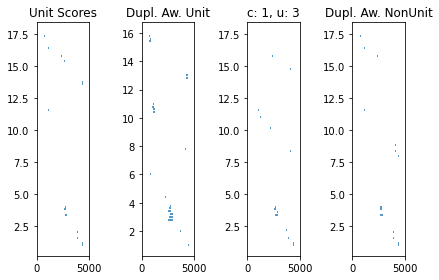

Mutation rate: 0.1


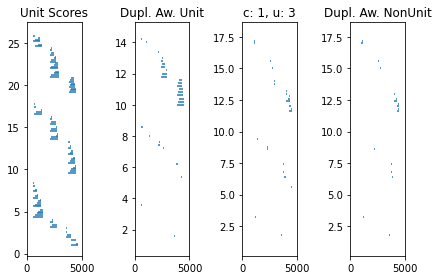

In [201]:
#Load duplication aware results with and without score weight modifications
duplAwUnitRes = loadHomologies("../simulations/homologies_gn100_rn400_gl1000_rl500_o3_m0*_c1_u1.txt", \
                               textSketches)
duplAwNonUnitRes = loadHomologies("../simulations/homologies_gn100_rn400_gl1000_rl500_o3_m0*_c1_u3.txt", \
                                  textSketches)
#Calculate min score thresholds for new duplication aware results
duplAwUnitMinScores = findMinScores(duplAwUnitRes, homInts)
duplAwNonUnitMinScores = findMinScores(duplAwNonUnitRes, homInts)
#Plot results
mRates = sorted(duplAwUnitRes.keys())
allRes = [results, duplAwUnitRes, nonUnitRes, duplAwNonUnitRes]
allMinScores = [minScores, duplAwUnitMinScores, nonUnitMinScores, duplAwNonUnitMinScores]
titles = ["Unit Scores", "Dupl. Aw. Unit", "c: 1, u: 3", "Dupl. Aw. NonUnit"]

for m in mRates:
    print("Mutation rate:", m)
    
    fig, axes = plt.subplots(1, len(allRes))
          
    for i in range(len(allRes)):
        maxY = 1.
        padding = 0.2
          
        for ps in allRes[i][m][:3]:
            toPlot = [p for p in ps if p[0] >= allMinScores[i][m]]
            axes[i].hlines([maxY + j * padding for j in range(len(toPlot))], [t[1] for t in toPlot], [t[2] for t \
                                                                                                      in toPlot])
            maxY += 1. + padding * len(toPlot)
        
        axes[i].set_xlim([0, 5000])
        axes[i].set_title(titles[i])
        
    plt.tight_layout()
    plt.show()

In [221]:
#Testing
#print(homInts[0][0])
#print([i for i in sorted(duplAwUnitRes[0][2], key=lambda r: r[0]) if i[0] >= duplAwUnitMinScores[0]])
#findMinScores({0: [duplAwUnitRes[0][0]]}, homInts)
#duplAwUnitMinScores = findMinScores(duplAwUnitRes, homInts)
#duplAwUnitMinScores
sorted(duplAwUnitRes[0][0], key=lambda r: r[0])

[(113, 1467, 2957),
 (113, 1457, 2951),
 (113, 1451, 2937),
 (113, 1437, 2917),
 (113, 1417, 2884),
 (113, 1384, 2879),
 (113, 1379, 2867),
 (113, 1367, 2857),
 (113, 1357, 2856),
 (113, 1356, 2843),
 (113, 1343, 2834),
 (113, 1334, 2829),
 (113, 1329, 2817),
 (113, 1317, 2809),
 (113, 1309, 2783),
 (113, 1283, 2754),
 (113, 1254, 2750),
 (113, 1250, 2660),
 (113, 1160, 2651),
 (113, 1151, 2650),
 (113, 1150, 2640),
 (113, 1140, 2628),
 (113, 1128, 2626),
 (113, 1126, 2618),
 (113, 1118, 2612),
 (113, 1112, 2575),
 (113, 1075, 2555),
 (113, 1055, 2553),
 (113, 1053, 2549),
 (113, 1049, 2548),
 (113, 1048, 2538),
 (113, 1038, 2528),
 (113, 1028, 2524),
 (113, 1024, 2523),
 (113, 1023, 2476),
 (113, 976, 2467),
 (113, 967, 2466),
 (113, 966, 2461),
 (113, 961, 2453),
 (113, 953, 2448),
 (113, 948, 2442),
 (113, 942, 2435),
 (113, 935, 2413),
 (113, 913, 2405),
 (113, 905, 2384),
 (113, 884, 2379),
 (113, 879, 2357),
 (113, 857, 2349),
 (113, 849, 2346),
 (113, 846, 2340),
 (113, 840, 233

# New Simulations - Single Pattern Occurrence in Text
[Back to Big Content Table](#Big-Table-of-Contents)

## Contents 2
* [Duplication Aware $t$-homology Detection](#Duplication-Aware-\$t\$\-homology-Detection-(1))
* [Using Length Normalized Scores](#Using-Length-Normalized-Scores)

In [152]:
#Get sketches of new texts
snglPttnTextSketches = getTextSketches("../simulations/searchPairs_gn100_rn200_gl1000_rl1000_o1_m0*")
#Load new results
snglPttnRes = loadHomologies("../simulations/homologies_gn100_rn200_gl1000_rl1000_o1_m0*", snglPttnTextSketches)
#Calculate pattern sketches for single pattern text pairs
snglPttnPatternSketches = loadPatternSketches("../simulations/searchPairs_gn100_rn200_gl1000_rl1000_o1_m0*")
#Calculate homology intervals for single pattern texts
snglPttnHomInts = calcHomIntervals(snglPttnTextSketches, snglPttnPatternSketches, 1000, 2000, 2500)
#Calculate thresholds
snglPttnMinScores = findMinScores(snglPttnRes, snglPttnHomInts)

print("Threshold scores for single pattern texts:")
print(snglPttnMinScores)
print("Min scores of single pattern texts:")

for m in snglPttnRes.keys():
    print(m, min([r[0] for p in snglPttnRes[m] for r in p]))

2259
At position 1009
Threshold scores for single pattern texts:
{0.1: -119, 0.0: 148, 0.02: -5, 0.07: -119, 0.09: -125, 0.04: -108, 0.08: -119, 0.03: -46, 0.06: -116, 0.01: 53, 0.05: -112}
Min scores of single pattern texts:
0.1 -119
0.0 43
0.02 -108
0.07 -119
0.09 -125
0.04 -111
0.08 -121
0.03 -111
0.06 -118
0.01 -68
0.05 -118


In [174]:
#Load nucmer results
NB_PAIRS = 100

def loadNucmerRes(filePaths):
    res = {}
    
    for f in glob(filePaths):
        mRate = float(f.split("_m")[1].split("_i")[0])
        pairID = int(f.split("_p")[1].split(".coords")[0])
        
        if not mRate in res:
            res[mRate] = [[] for i in range(NB_PAIRS)]
            
        c = 1
        
        for l in open(f, 'r'):
            if c > 5:
                res[mRate][pairID].append([-inf] + [int(i) for i in l.split('|')[0].strip().split(' ') if \
                                                    i.isnumeric()])
                
            c += 1
            
    return res

In [175]:
snglPttnNucRes = loadNucmerRes("../simulations/nucmerAlignments_gn100_rn200_gl1000_rl1000_o1_m0*.coords")

In [176]:
#Testing
snglPttnNucRes

{0.06: [[[-inf, 1001, 1996]],
  [],
  [],
  [[-inf, 1035, 2001]],
  [[-inf, 1001, 1975]],
  [[-inf, 1001, 1981]],
  [[-inf, 1001, 1980]],
  [],
  [],
  [],
  [[-inf, 1001, 1993]],
  [[-inf, 1001, 1975]],
  [],
  [[-inf, 1001, 1985]],
  [[-inf, 1001, 1984]],
  [[-inf, 1005, 1991]],
  [],
  [],
  [],
  [[-inf, 1001, 1996]],
  [],
  [[-inf, 1001, 1993]],
  [],
  [[-inf, 1004, 1991]],
  [],
  [[-inf, 1001, 1993]],
  [[-inf, 1003, 1988]],
  [[-inf, 1004, 1987]],
  [[-inf, 1001, 1988]],
  [],
  [[-inf, 1001, 1998]],
  [],
  [[-inf, 1002, 1992]],
  [],
  [],
  [],
  [],
  [],
  [[-inf, 1008, 1965]],
  [],
  [],
  [],
  [[-inf, 1004, 1992]],
  [],
  [],
  [],
  [],
  [],
  [[-inf, 1001, 1988]],
  [],
  [[-inf, 1001, 1975]],
  [[-inf, 1004, 1978]],
  [],
  [],
  [],
  [],
  [[-inf, 1001, 1990]],
  [],
  [[-inf, 1008, 2004]],
  [[-inf, 1001, 1965]],
  [[-inf, 1001, 1990]],
  [[-inf, 1004, 1980]],
  [[-inf, 1012, 1991]],
  [],
  [],
  [],
  [],
  [],
  [[-inf, 1001, 1993]],
  [],
  [],
  [],
  []

Mutation rate: 0.0


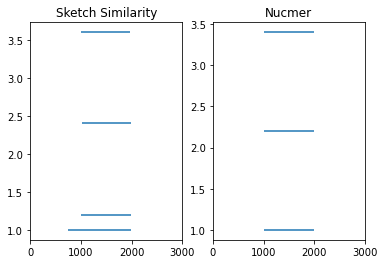

Mutation rate: 0.01


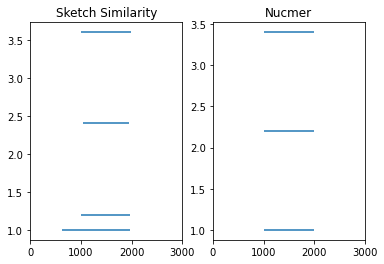

Mutation rate: 0.02


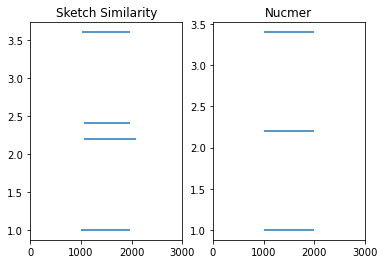

Mutation rate: 0.03


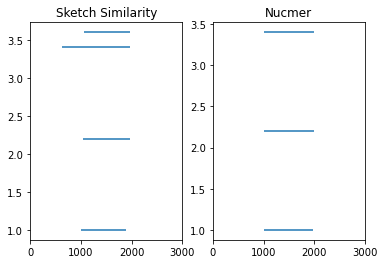

Mutation rate: 0.04


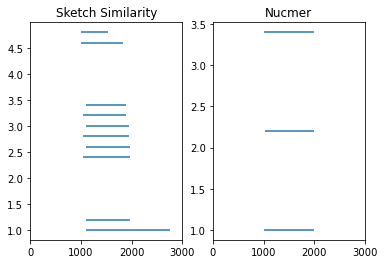

Mutation rate: 0.05


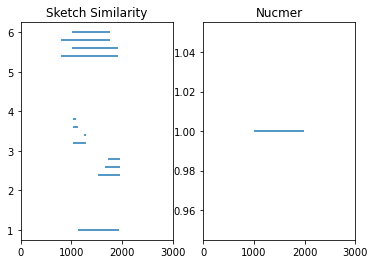

Mutation rate: 0.06


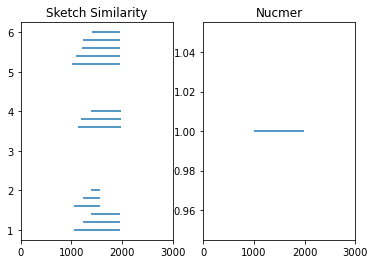

Mutation rate: 0.07


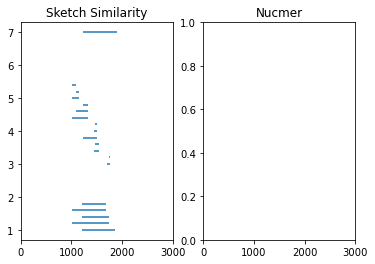

Mutation rate: 0.08


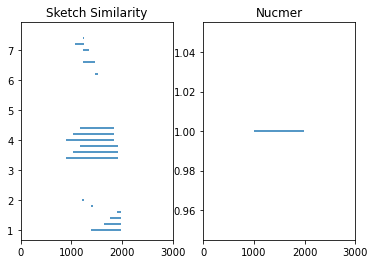

Mutation rate: 0.09


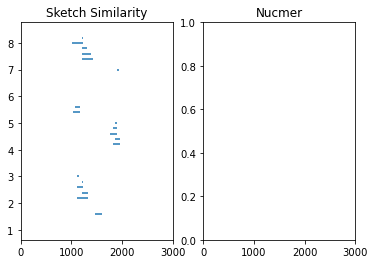

Mutation rate: 0.1


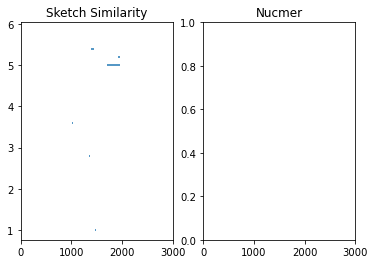

In [179]:
mRates = sorted(snglPttnRes.keys())
allRes = [snglPttnRes, snglPttnNucRes]
titles = ["Sketch Similarity", "Nucmer"]

for m in mRates:
    print("Mutation rate:", m)
    
    fig, axes = plt.subplots(1, 2)
    
    for i in range(len(allRes)):
        maxY = 1.
        padding = 0.2
          
        for ps in allRes[i][m][:3]:
            toPlot = [p for p in ps if i == 1 or p[0] >= snglPttnMinScores[m]]
            
            #Testing
            #print(toPlot)
            
            axes[i].hlines([maxY + j * padding for j in range(len(toPlot))], [t[1] for t in toPlot], [t[2] for t \
                                                                                                      in toPlot])
            maxY += 1. + padding * len(toPlot)
            axes[i].set_xlim([0, 3000])
            
        axes[i].set_title(titles[i])
        
    plt.show()

## Duplication Aware $t$-homology Detection (1)
[Back to Contents](#Contents-2)

Mutation rate: 0.0


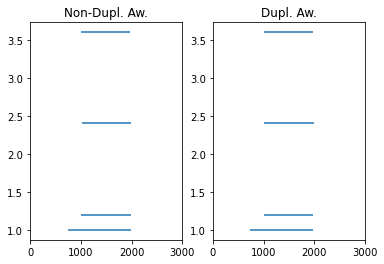

Mutation rate: 0.01


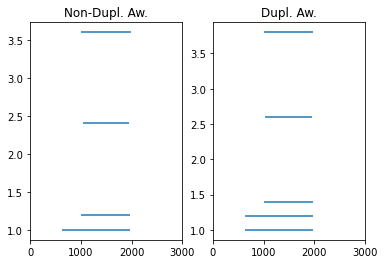

Mutation rate: 0.02


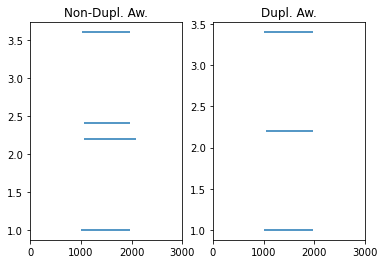

Mutation rate: 0.03


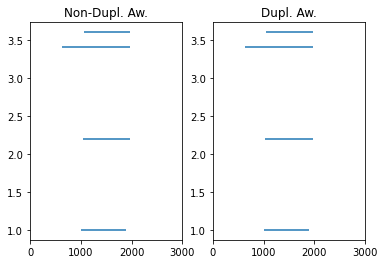

Mutation rate: 0.04


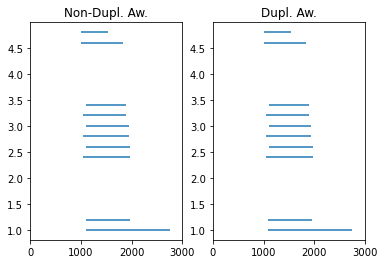

Mutation rate: 0.05


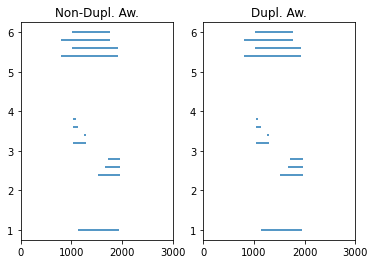

Mutation rate: 0.06


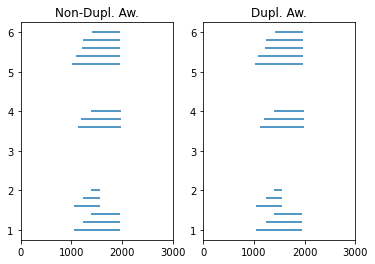

Mutation rate: 0.07


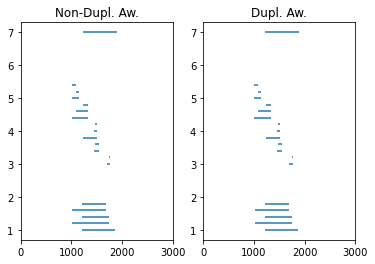

Mutation rate: 0.08


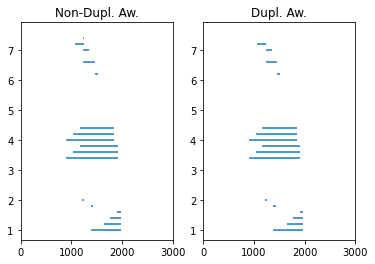

Mutation rate: 0.09


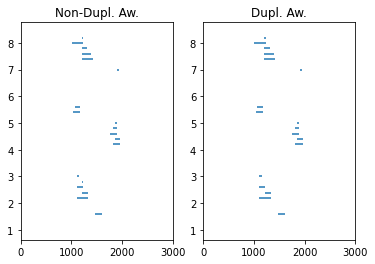

Mutation rate: 0.1


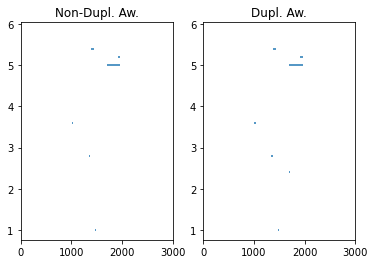

In [429]:
duplAwSnglPttnRes = loadHomologies("../simulations/homologies_gn100_rn200_gl1000_rl1000_o1_m0*_u1.txt", \
                                   snglPttnTextSketches, False)
duplAwSnglPttnMinScores = findMinScores(duplAwSnglPttnRes, snglPttnHomInts)
mRates = sorted(snglPttnRes.keys())
allRes = [snglPttnRes, duplAwSnglPttnRes]
allSnglPttnMinScores = [snglPttnMinScores, duplAwSnglPttnMinScores]
titles = ["Non-Dupl. Aw.", "Dupl. Aw."]

for m in mRates:
    print("Mutation rate:", m)
    
    fig, axes = plt.subplots(1, 2)
    
    for i in range(len(allRes)):
        maxY = 1.
        padding = 0.2
          
        for ps in allRes[i][m][:3]:
            toPlot = [p for p in ps if p[0] >= allSnglPttnMinScores[i][m]]
            axes[i].hlines([maxY + j * padding for j in range(len(toPlot))], [t[1] for t in toPlot], [t[2] for t \
                                                                                                      in toPlot])
            maxY += 1. + padding * len(toPlot)
            axes[i].set_xlim([0, 3000])
            
        axes[i].set_title(titles[i])
        
    plt.show()

In [438]:
mRates = sorted(snglPttnRes.keys())
allRes = [snglPttnRes, duplAwSnglPttnRes]
allSnglPttnMinScores = [snglPttnMinScores, duplAwSnglPttnMinScores]
titles = ["Non-Dupl. Aw.", "Dupl. Aw."]

print("Average number of t-homologies above threshold")

for m in mRates:
    print("Mutation rate:", m)
    
    for i in range(len(allRes)):
        nbRes = []
        
        for ps in allRes[i][m]:
            nbRes.append(len([p for p in ps if p[0] >= allSnglPttnMinScores[i][m]]))
            
        print(f"{titles[i]}: mean:{mean(nbRes)}, std:{std(nbRes)}")

Average number of t-homologies above threshold
Mutation rate: 0.0
Non-Dupl. Aw.: mean:1.35, std:0.6062177826491072
Dupl. Aw.: mean:1.19, std:0.39230090491866065
Mutation rate: 0.01
Non-Dupl. Aw.: mean:1.41, std:0.6647555941848102
Dupl. Aw.: mean:1.29, std:0.5530822723609934
Mutation rate: 0.02
Non-Dupl. Aw.: mean:1.75, std:1.4026760139105539
Dupl. Aw.: mean:1.62, std:1.2631706139710501
Mutation rate: 0.03
Non-Dupl. Aw.: mean:1.72, std:0.8009993757800314
Dupl. Aw.: mean:1.63, std:0.743706931526122
Mutation rate: 0.04
Non-Dupl. Aw.: mean:3.46, std:2.4956762610563095
Dupl. Aw.: mean:3.51, std:2.6134077370360713
Mutation rate: 0.05
Non-Dupl. Aw.: mean:5.06, std:3.13949040450835
Dupl. Aw.: mean:5.09, std:3.212771389314839
Mutation rate: 0.06
Non-Dupl. Aw.: mean:7.51, std:4.186872341020203
Dupl. Aw.: mean:7.55, std:4.200892762258993
Mutation rate: 0.07
Non-Dupl. Aw.: mean:9.02, std:4.002449250146714
Dupl. Aw.: mean:9.01, std:4.041027097162305
Mutation rate: 0.08
Non-Dupl. Aw.: mean:8.72, std

## Using Length Normalized Scores
[Back to Contents](#Contents-2)

Mutation rate: 0.0


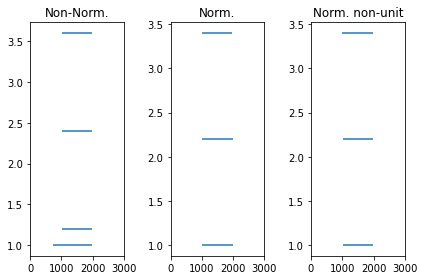

Mutation rate: 0.01


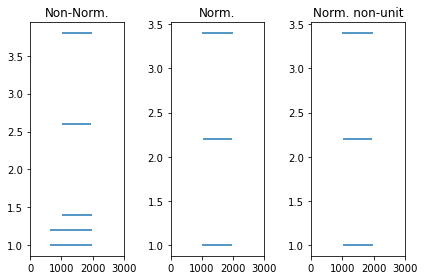

Mutation rate: 0.02


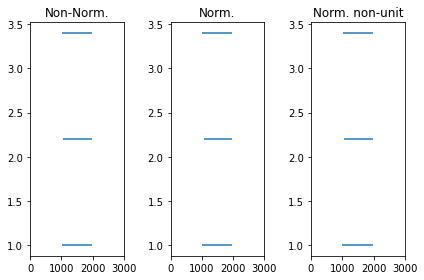

Mutation rate: 0.03


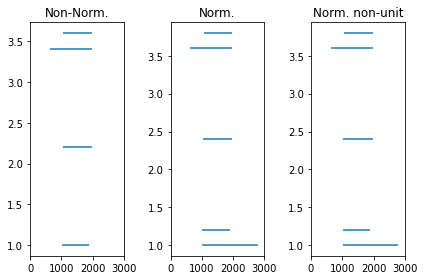

Mutation rate: 0.04


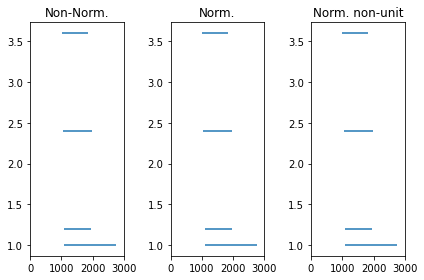

Mutation rate: 0.05


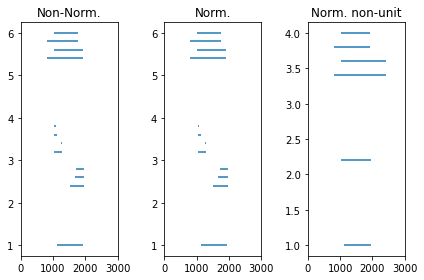

Mutation rate: 0.06


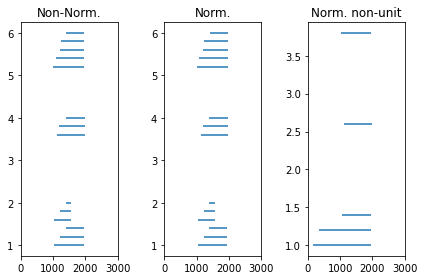

Mutation rate: 0.07


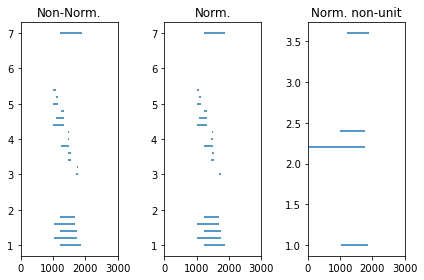

Mutation rate: 0.08


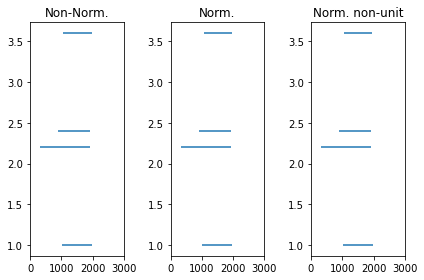

Mutation rate: 0.09


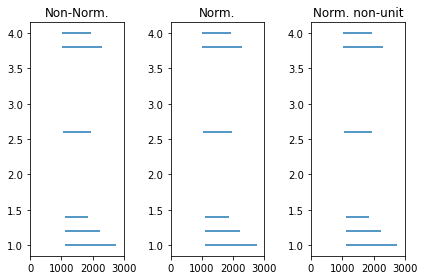

Mutation rate: 0.1


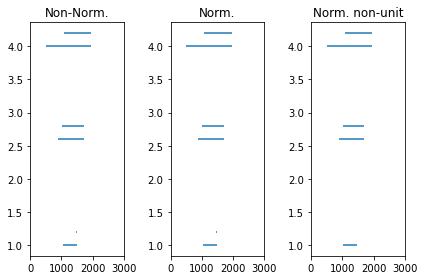

In [436]:
nonNormDuplAwSnglPttnRes = loadHomologies("../simulations/homologies_gn100_rn200_gl1000_rl1000_o1_m0*_u1.txt", \
                                   snglPttnTextSketches, False)
normDuplAwSnglPttnRes = loadHomologies("../simulations/homologies_gn100_rn200_gl1000_rl1000_o1_m0*_u1.txt", \
                                   snglPttnTextSketches, True)
normDuplAwNonUnitSnglPttnRes = loadHomologies("../simulations/homologies_gn100_rn200_gl1000_rl1000_o1_m0*c9_u1.txt"\
                                              , snglPttnTextSketches, True)
nonNormDuplAwSnglPttnMinScores = findMinScores(nonNormDuplAwSnglPttnRes, snglPttnHomInts)
normDuplAwSnglPttnMinScores = findMinScores(normDuplAwSnglPttnRes, snglPttnHomInts)
normDuplAwNonUnitSnglPttnMinScores = findMinScores(normDuplAwNonUnitSnglPttnRes, snglPttnHomInts)
mRates = sorted(nonNormDuplAwSnglPttnRes.keys())
allRes = [nonNormDuplAwSnglPttnRes, normDuplAwSnglPttnRes, normDuplAwNonUnitSnglPttnRes]
allSnglPttnMinScores = [nonNormDuplAwSnglPttnMinScores, normDuplAwSnglPttnMinScores, \
                        normDuplAwNonUnitSnglPttnMinScores]
titles = ["Non-Norm.", "Norm.", "Norm. non-unit"]

for m in mRates:
    print("Mutation rate:", m)
    
    fig, axes = plt.subplots(1, len(titles))
    
    for i in range(len(allRes)):
        maxY = 1.
        padding = 0.2
          
        for ps in allRes[i][m][:3]:
            toPlot = [p for p in ps if p[0] >= allSnglPttnMinScores[i][m]]
            axes[i].hlines([maxY + j * padding for j in range(len(toPlot))], [t[1] for t in toPlot], [t[2] for t \
                                                                                                      in toPlot])
            maxY += 1. + padding * len(toPlot)
            axes[i].set_xlim([0, 3000])
            
        axes[i].set_title(titles[i])
        
    plt.tight_layout()
    plt.show()

In [439]:
mRates = sorted(nonNormDuplAwSnglPttnRes.keys())
allRes = [nonNormDuplAwSnglPttnRes, normDuplAwSnglPttnRes, normDuplAwNonUnitSnglPttnRes]
allSnglPttnMinScores = [nonNormDuplAwSnglPttnMinScores, normDuplAwSnglPttnMinScores, \
                        normDuplAwNonUnitSnglPttnMinScores]
titles = ["Non-Norm.", "Norm.", "Norm. non-unit"]

print("Average number of t-homologies above threshold")

for m in mRates:
    print("Mutation rate:", m)
    
    for i in range(len(allRes)):
        nbRes = []
        
        for ps in allRes[i][m]:
            nbRes.append(len([p for p in ps if p[0] >= allSnglPttnMinScores[i][m]]))
            
        print(f"{titles[i]}: mean:{mean(nbRes)}, std:{std(nbRes)}")

Average number of t-homologies above threshold
Mutation rate: 0.0
Non-Norm.: mean:1.42, std:0.6193545026880809
Norm.: mean:1.0, std:0.0
Norm. non-unit: mean:1.0, std:0.0
Mutation rate: 0.01
Non-Norm.: mean:1.58, std:0.7639371701913711
Norm.: mean:1.05, std:0.21794494717703367
Norm. non-unit: mean:1.05, std:0.21794494717703367
Mutation rate: 0.02
Non-Norm.: mean:1.69, std:1.3615799645999498
Norm.: mean:1.24, std:0.512249938994628
Norm. non-unit: mean:1.24, std:0.512249938994628
Mutation rate: 0.03
Non-Norm.: mean:1.63, std:0.743706931526122
Norm.: mean:1.93, std:1.0124722218411724
Norm. non-unit: mean:1.53, std:0.7543871685016919
Mutation rate: 0.04
Non-Norm.: mean:1.7, std:0.9643650760992953
Norm.: mean:1.63, std:0.7570336848516056
Norm. non-unit: mean:1.63, std:0.7570336848516056
Mutation rate: 0.05
Non-Norm.: mean:5.09, std:3.212771389314839
Norm.: mean:5.1, std:3.189043743820395
Norm. non-unit: mean:1.54, std:0.8534635317340749
Mutation rate: 0.06
Non-Norm.: mean:7.55, std:4.2008927

# Precision and Recall Evaluation of minimap2
[Back to Big Table of Contents](#Big-Table-of-Contents)

### Evaluation Criteria

* Only primary mappings are considered for evaluation.
* We use minimap2's default mapping strategy for ONT data as presented on their website.
* A read is considered correctly mapped if true read position and mapping
    * lie on the same chromosome,
    * lie on the same strand
    * and overlap by at least {50, 80, 90, 95, 99}%.

In [338]:
THRESHOLDS = [0.5, 0.8, 0.9, 0.95, 0.99]

In [22]:
MAXOFFS = range(0, 1100, 100)

In [10]:
import gzip
from Bio import SeqIO
from glob import glob
from math import inf

def compareMappingAndTruth(pathToRef, pathToTruthRegEx, pathToMapping):
    #Load chromosome names from reference
    chromNames = [r.id for r in SeqIO.parse(open(pathToRef, 'r'), "fasta")]
    
    #Load truth
    readInfos = {}
    
    for f in glob(pathToTruthRegEx):
        cnt = 0
    
        for l in gzip.open(f, 'rt'):
            cnt += 1
            elems = [e for e in l.strip().split(' ') if e != ""]
            
            #Get infos from reference line
            if cnt % 4 == 2:
                start = int(elems[2])
                length = int(elems[3])
            
            #Get infos from read line and save
            if cnt % 4 == 3:
                curChromName = chromNames[int(elems[1].split('S')[1].split('_')[0]) - 1]
                readInfos[elems[1]] = [curChromName, elems[4], start, start + length - 1]
                
    #Load SAM file
    cnt = 0
    nbSndAlgns = 0
    nbSuplAlgns = 0
    
    for l in gzip.open(pathToMapping, 'rt'):
        cnt += 1
        isSuplAlgn = False
        
        #We are not interested in header lines
        if l.startswith('@'):
            continue
            
        elems = l.split('\t')
        strandsEqual = readInfos[elems[0]][1] == '+'    
        elems[1] = int(elems[1])
        
        #We have a supplementary alignment...whatever that means...
        if elems[1] >= 2048:
            elems[1] -= 2048
            nbSuplAlgns += 1
            isSuplAlgn = True
            
            #print(f"WARNING: Line {cnt} in SAM file is marked as supplementary alignment. Read name is {elems[0]}")
                
        #The read was flagged as a duplicate
        if elems[1] >= 1024:
            elems[1] -= 1024
            
            print(f"WARNING: Line {cnt} in SAM file says that a read was flagged as a duplicate")
            
        #A read failed the quality check
        if elems[1] >= 512:
            elems[1] -= 512
            
            print(f"WARNING: Read refered to in Line {cnt} failed the quality check")
            
        #The given alignment is secondary
        if elems[1] >= 256:
            elems[1] -= 256
            nbSndAlgns += 1
            continue
            
        #We have found the second mate of a read pair
        if elems[1] >= 128:
            elems[1] -= 128
            
            print(f"WARNING: In Line {cnt}, we have found the second mate of a read pair")
            
        #We have found the first mate of a read pair
        if elems[1] >= 64:
            elems[1] -= 64
            
            print(f"WARNING: In Line {cnt}, we have found the first mate of a read pair")
            
        #Mate of this guy aligned in reverse direction
        if elems[1] >= 32:
            elems[1] -= 32
            
            print(f"WARNING: In Line {cnt}, we have found a mate who's other mate aligned in reverse direction")
            
        #Read aligned in reverse direction
        if elems[1] >= 16:
            elems[1] -= 16
            
            #Sanity check: Have we seen a mapping for this read before?
            if len(readInfos[elems[0]]) > 4 and not isSuplAlgn:
                print(f"WARNING: In Line {cnt}, we consider a mapping of a read for which we have already " +\
                      "considered a mapping before")
                
            strandsEqual = readInfos[elems[0]][1] == '-'
            
        #Read is part of pair and mate was not aligned
        if elems[1] >= 8:
            elems[1] -= 8
            
            print(f"WARNING: In Line {cnt}, we consider a read whose mate was not aligned")
            
        #Read could not be aligned
        if elems[1] >= 4:
            elems[1] -= 4
            
            #Sanity check: Have we seen a mapping for this read before?
            if len(readInfos[elems[0]]) > 4 and not isSuplAlgn:
                print(f"WARNING: In Line {cnt}, we consider a mapping of a read for which we have already " +\
                      "considered a mapping before")
                
                readInfos[elems[0]][4] = inf
            else:
                readInfos[elems[0]].append(inf)
                
            continue
            
        #Read is part of properly aligned pair
        if elems[1] >= 2:
            elems[1] -= 2
            
            print(f"WARNING: The read considered in Line {cnt} belongs to a properly aligned read pair")
            
        #Read is paired
        if elems[1] >= 1:
            elems[1] -= 1
            
            print(f"WARNING: The read considered in Line {cnt} belongs to a pair")
            
        #Check if read was mapped to the correct chromosome
        chromsEqual = elems[2] == readInfos[elems[0]][0]
        #Calculate end position of mapping
        start = int(elems[3])
        end = start - 1
        nbOps = ""
        
        for c in elems[5]:
            if c.isdigit():
                nbOps += c
            #Run of matches found
            elif c == 'M' or 'D' or 'N' or '=' or 'X':
                end += int(nbOps)
                nbOps = ""
            elif c == 'I' or 'S' or 'H' or 'P':
                nbOps = ""
            else:
                print(f"ERROR: Unrecognized operation {c} detected in CIGAR string in Line {cnt}")
                
        #Check which kind of overlap between true location and mapping we are dealing with
        if readInfos[elems[0]][3] < start or end < readInfos[elems[0]][2]:
            mappingOffset = readInfos[elems[0]][3] - readInfos[elems[0]][2] + end - start + 2
        else:
            #Mapping contained inside true position
            if readInfos[elems[0]][2] < start and readInfos[elems[0]][3] > end:
                #overlap = end - start + 1
                #enoughOverlap = overlap >= (readInfos[elems[0]][3] - readInfos[elems[0]][2] + 1) * overlapThres
                mappingOffset = start - readInfos[elems[0]][2] + readInfos[elems[0]][3] - end + 2
            #Mapping and true position partly overlapping with true position starting earlier
            elif readInfos[elems[0]][2] <= start and readInfos[elems[0]][3] <= end:
                #overlap = readInfos[elems[0]][3] - start
                #enoughOverlap = overlap >= (readInfos[elems[0]][3] - readInfos[elems[0]][2] + 1) * overlapThres
                mappingOffset = start - readInfos[elems[0]][2] + end - readInfos[elems[0]][3] + 2
            #Mapping and true position partly overlapping with mapping starting earlier
            elif start <= readInfos[elems[0]][2] and end <= readInfos[elems[0]][3]:
                #overlap = end - readInfos[elems[0]][2]
                #enoughOverlap = overlap >= (readInfos[elems[0]][3] - readInfos[elems[0]][2] + 1) * overlapThres
                mappingOffset = readInfos[elems[0]][2] - start + readInfos[elems[0]][3] - end + 2
            #True position contained inside mapping
            elif start < readInfos[elems[0]][2] and end > readInfos[elems[0]][3]:
                #overlap = readInfos[elems[0]][3] - readInfos[elems[0]][2] + 1
                #enoughOverlap = overlap >= end - start + 1
                mappingOffset = readInfos[elems[0]][2] - start + end - readInfos[elems[0]][3] + 2
            else:
                print(f"ERROR: Overlap could not be calculated in Line {cnt}\nTrue coordinates: " + \
                      f"{readInfos[elems[0]][2]},{readInfos[elems[0]][3]}\nMapping coordinates: {start},{end}")
                
        #Sanity check: Have we seen a mapping for this read before?
        if len(readInfos[elems[0]]) > 4 and not isSuplAlgn:
            print(f"WARNING: In Line {cnt}, we consider a mapping of a read for which we have already " +\
                      "considered a mapping before")
            
            if chromsEqual and strandsEqual:
                readInfos[elems[0]][4] = mappingOffset
            else:
                readInfos[elems[0]][4] = inf
        else:
            if chromsEqual and strandsEqual:
                readInfos[elems[0]].append(mappingOffset)
            else:
                readInfos[elems[0]].append(inf)
        
    print(f"Comparison done\nSkipped {nbSndAlgns} secondary alignments")
    
    return readInfos

In [337]:
def countMappingOutcomes(readInfos):
    nbNotMapped = 0
    nbMappedCorrectly = 0
    nbMappedIncorrectly = 0

    for r in readInfos:
        if len(readInfos[r]) < 5:
            nbNotMapped += 1
        elif readInfos[r][4]:
            nbMappedCorrectly += 1
        else:
            nbMappedIncorrectly += 1
        
    #Testing
    #print(f"Result of mapping: {nbNotMapped} reads could not be mapped, {nbMappedCorrectly} reads could be " + \
    #      f"mapped correctly and {nbMappedIncorrectly} reads were mapped incorrectly")
    
    return [nbNotMapped, nbMappedCorrectly, nbMappedIncorrectly]

In [344]:
def plotFracOfCorrectMappings(outcomes):
    plt.plot(THRESHOLDS, [float(outcomes[t][1]) / sum(outcomes[t]) for t in THRESHOLDS], 'o-')
    plt.xlabel("Min overlap ratio")
    plt.ylabel("Fraction of correctly mapped reads")
    plt.show()

In [18]:
from matplotlib import pyplot as plt

def plotNbMappingsPerOffset(miniOutcomes, bwaOutcomes):
    for ep in sorted(bwaOutcomes.keys(), key=lambda k: int(k.split(':')[0])):
        plt.plot(MAXOFFS, [len([m for m in miniOutcomes[ep] if miniOutcomes[ep][m][4] <= mo]) / \
                           len(miniOutcomes[ep]) for mo in MAXOFFS], 'o-', label=ep + " (mm2)")
        plt.plot(MAXOFFS, [len([m for m in bwaOutcomes[ep] if bwaOutcomes[ep][m][4] <= mo]) / \
                          len(bwaOutcomes[ep]) for mo in MAXOFFS], '+-', label=ep + " (bwa)")
    
    plt.title("Percent mappings per max offset")
    plt.xlabel("Max offset (bp)")
    plt.ylabel("Fraction of mapped reads")
    plt.legend()
    plt.show()

## Dataset: Salmonella Enterica

In [13]:
miniOutcomesPerPattern = {}

for f in glob("../simulations/minimap2Res/SAL_GB9998AA_AS_cR103_ep*.sam.gz"):
    ep = f.split("_ep")[1].split('_s')[0]
    
    print("Error pattern:", ep)
    
    
    miniOutcomesPerPattern[ep] = compareMappingAndTruth("../simulations/genomes/SAL_GB9998AA_AS.fasta", \
                                       glob(f"../simulations/reads/SAL_GB9998AA_AS_cR103_ep{ep}_s*.maf.gz")[0], \
                                       glob(f"../simulations/minimap2Res/SAL_GB9998AA_AS_cR103_ep{ep}_s*.sam.gz"\
                                           )[0])

Error pattern: 368:496:736
Comparison done
Skipped 82 secondary alignments
Error pattern: 0:0:0
Comparison done
Skipped 88 secondary alignments
Error pattern: 184:248:368
Comparison done
Skipped 106 secondary alignments
Error pattern: 46:62:92
Comparison done
Skipped 94 secondary alignments
Error pattern: 23:31:46
Comparison done
Skipped 70 secondary alignments
Error pattern: 92:124:184
Comparison done
Skipped 66 secondary alignments


In [15]:
bwaOutcomesPerPattern = {}

for f in glob("../simulations/bwamemRes/SAL_GB9998AA_AS_cR103_ep*.sam.gz"):
    ep = f.split("_ep")[1].split('_s')[0]
    
    print("Error pattern:", ep)
     
    bwaOutcomesPerPattern[ep] = compareMappingAndTruth("../simulations/genomes/SAL_GB9998AA_AS.fasta", \
                                       glob(f"../simulations/reads/SAL_GB9998AA_AS_cR103_ep{ep}_s*.maf.gz")[0], \
                                       glob(f"../simulations/bwamemRes/SAL_GB9998AA_AS_cR103_ep{ep}_s*.sam.gz")[0])

Error pattern: 368:496:736
Comparison done
Skipped 0 secondary alignments
Error pattern: 184:248:368
Comparison done
Skipped 0 secondary alignments
Error pattern: 46:62:92
Comparison done
Skipped 0 secondary alignments
Error pattern: 23:31:46
Comparison done
Skipped 0 secondary alignments
Error pattern: 92:124:184
Comparison done
Skipped 0 secondary alignments


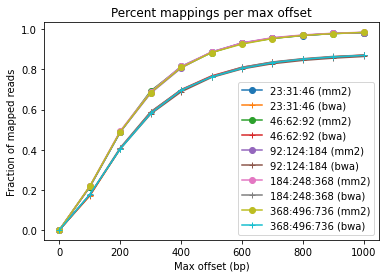

In [23]:
plotNbMappingsPerOffset(miniOutcomesPerPattern, bwaOutcomesPerPattern)

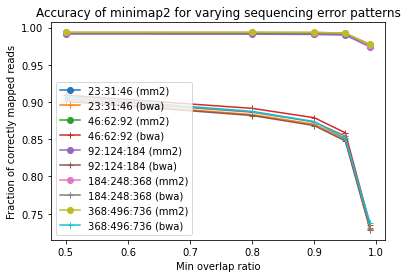

In [370]:
for ep in sorted(bwaOutcomesPerPattern.keys(), key=lambda k: int(k.split(':')[0])):
    plt.plot(THRESHOLDS, [float(outcomesPerPattern[ep][t][1]) / sum(outcomesPerPattern[ep][t]) for t in \
                          THRESHOLDS], 'o-', label=ep + " (mm2)")
    plt.plot(THRESHOLDS, [float(bwaOutcomesPerPattern[ep][t][1]) / sum(bwaOutcomesPerPattern[ep][t]) for t in \
                          THRESHOLDS], '+-', label=ep + " (bwa)")
    
plt.title("Accuracy of minimap2 for varying sequencing error patterns")
plt.xlabel("Min overlap ratio")
plt.ylabel("Fraction of correctly mapped reads")
plt.legend()
plt.show()

## Dataset: Human Chromosome 22

In [24]:
miniOutcomesPerPattern = {}

for f in glob("../simulations/minimap2Res/humanChr20_cR103_ep*.sam.gz"):
    ep = f.split("_ep")[1].split('_s')[0]
    
    print("Error pattern:", ep)
    
    miniOutcomesPerPattern[ep] = compareMappingAndTruth("../simulations/genomes/humanChr20.fasta", \
                                       glob(f"../simulations/reads/humanChr20_cR103_ep{ep}_s*.maf.gz")[0], \
                                       glob(f"../simulations/minimap2Res/humanChr20_cR103_ep{ep}_s*.sam.gz")[0])

Error pattern: 23:31:46
Comparison done
Skipped 4180 secondary alignments
Error pattern: 46:62:92
Comparison done
Skipped 4180 secondary alignments
Error pattern: 368:496:736
Comparison done
Skipped 4180 secondary alignments
Error pattern: 184:248:368
Comparison done
Skipped 4180 secondary alignments
Error pattern: 92:124:184
Comparison done
Skipped 4180 secondary alignments


In [25]:
bwaOutcomesPerPattern = {}

for f in glob("../simulations/bwamemRes/humanChr20_cR103_ep*.sam.gz"):
    ep = f.split("_ep")[1].split('_s')[0]
    
    print("Error pattern:", ep)
     
    bwaOutcomesPerPattern[ep] = compareMappingAndTruth("../simulations/genomes/humanChr20.fasta", \
                                       glob(f"../simulations/reads/humanChr20_cR103_ep{ep}_s*.maf.gz")[0], \
                                       glob(f"../simulations/bwamemRes/humanChr20_cR103_ep{ep}_s*.sam.gz")[0])

Error pattern: 23:31:46
Comparison done
Skipped 0 secondary alignments
Error pattern: 46:62:92
Comparison done
Skipped 0 secondary alignments
Error pattern: 368:496:736
Comparison done
Skipped 0 secondary alignments
Error pattern: 184:248:368
Comparison done
Skipped 0 secondary alignments
Error pattern: 92:124:184
Comparison done
Skipped 0 secondary alignments


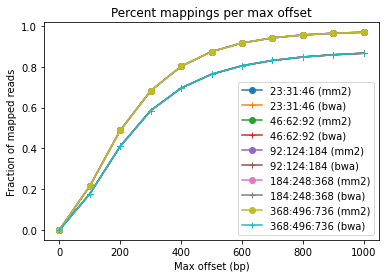

In [26]:
plotNbMappingsPerOffset(miniOutcomesPerPattern, bwaOutcomesPerPattern)

In [384]:
miniOutcomesPerPattern = {}

for f in glob("../simulations/minimap2Res/humanChr20_cR103_ep*.sam"):
    ep = f.split("_ep")[1].split('_s')[0]
    miniOutcomesPerPattern[ep] = {}
    
    print("Error pattern:", ep)
    
    for t in THRESHOLDS:
        print(f"Threshold: {t}")
        
        readInfos = compareMappingAndTruth("../simulations/genomes/humanChr20.fasta", \
                                       f"../simulations/reads/humanChr20_cR103_ep{ep}.maf", \
                                       f"../simulations/minimap2Res/humanChr20_cR103_ep{ep}.sam", t)
        miniOutcomesPerPattern[ep][t] = countMappingOutcomes(readInfos)

Error pattern: 184:248:368
Threshold: 0.5
Comparison done
Skipped 4180 secondary alignments
Threshold: 0.8
Comparison done
Skipped 4180 secondary alignments
Threshold: 0.9
Comparison done
Skipped 4180 secondary alignments
Threshold: 0.95
Comparison done
Skipped 4180 secondary alignments
Threshold: 0.99
Comparison done
Skipped 4180 secondary alignments
Error pattern: 23:31:46
Threshold: 0.5
Comparison done
Skipped 4180 secondary alignments
Threshold: 0.8
Comparison done
Skipped 4180 secondary alignments
Threshold: 0.9
Comparison done
Skipped 4180 secondary alignments
Threshold: 0.95
Comparison done
Skipped 4180 secondary alignments
Threshold: 0.99
Comparison done
Skipped 4180 secondary alignments
Error pattern: 92:124:184
Threshold: 0.5
Comparison done
Skipped 4180 secondary alignments
Threshold: 0.8
Comparison done
Skipped 4180 secondary alignments
Threshold: 0.9
Comparison done
Skipped 4180 secondary alignments
Threshold: 0.95
Comparison done
Skipped 4180 secondary alignments
Threshol

In [389]:
bwaOutcomesPerPattern = {}

for f in glob("../simulations/bwamemRes/humanChr20_cR103_ep*.sam.gz"):
    ep = f.split("_ep")[1].split('_s')[0]
    bwaOutcomesPerPattern[ep] = {}
    
    print("Error pattern:", ep)
    
    for t in THRESHOLDS:
        print(f"Threshold: {t}")
        
        readInfos = compareMappingAndTruth("../simulations/genomes/humanChr20.fasta", \
                                       f"../simulations/reads/humanChr20_cR103_ep{ep}.maf.gz", \
                                       f"../simulations/bwamemRes/humanChr20_cR103_ep{ep}.sam.gz", t)
        bwaOutcomesPerPattern[ep][t] = countMappingOutcomes(readInfos)

Error pattern: 23:31:46_s1657921994
Threshold: 0.5
Comparison done
Skipped 0 secondary alignments
Threshold: 0.8
Comparison done
Skipped 0 secondary alignments
Threshold: 0.9
Comparison done
Skipped 0 secondary alignments
Threshold: 0.95
Comparison done
Skipped 0 secondary alignments
Threshold: 0.99
Comparison done
Skipped 0 secondary alignments
Error pattern: 46:62:92_s1657921994
Threshold: 0.5
Comparison done
Skipped 0 secondary alignments
Threshold: 0.8
Comparison done
Skipped 0 secondary alignments
Threshold: 0.9
Comparison done
Skipped 0 secondary alignments
Threshold: 0.95
Comparison done
Skipped 0 secondary alignments
Threshold: 0.99
Comparison done
Skipped 0 secondary alignments
Error pattern: 368:496:736_s1657921994
Threshold: 0.5
Comparison done
Skipped 0 secondary alignments
Threshold: 0.8
Comparison done
Skipped 0 secondary alignments
Threshold: 0.9
Comparison done
Skipped 0 secondary alignments
Threshold: 0.95
Comparison done
Skipped 0 secondary alignments
Threshold: 0.99


In [393]:
corrKeyDict = {}

for k in bwaOutcomesPerPattern.keys():
    corrKeyDict[k.split('_')[0]] = bwaOutcomesPerPattern[k]
    
bwaOutcomesPerPattern = corrKeyDict

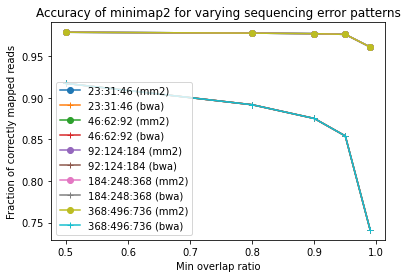

In [394]:
for ep in sorted(bwaOutcomesPerPattern.keys(), key=lambda k: int(k.split(':')[0])):
    plt.plot(THRESHOLDS, [float(miniOutcomesPerPattern[ep][t][1]) / sum(miniOutcomesPerPattern[ep][t]) for t in \
                          THRESHOLDS], 'o-', label=ep + " (mm2)")
    plt.plot(THRESHOLDS, [float(bwaOutcomesPerPattern[ep][t][1]) / sum(bwaOutcomesPerPattern[ep][t]) for t in \
                          THRESHOLDS], '+-', label=ep + " (bwa)")
    
plt.title("Accuracy of minimap2 for varying sequencing error patterns")
plt.xlabel("Min overlap ratio")
plt.ylabel("Fraction of correctly mapped reads")
plt.legend()
plt.show()

# Simulation Run 3: FindThoms (C++) vs. minimap2 vs. Winnowmap2
[Back to Big Table of Contents](#Big-Table-of-Contents)

## Contents 3

* [Total Mappings Found](#Total-Mappings-Found)
* [Total Mappings for Different Reward Scores](#Total-Mappings-for-Different-Reward-Scores)
* [Total Mappings for Different Thresholds](#Total-Mappings-for-Different-Thresholds)
* [Total Mappings for Different $k$-mer sizes](#Total-Mappings-for-Different-\$k\$\-mer-sizes)
* [Total Mappings Based on Confidence Interval Thresholds](#Total-Mappings-Based-on-Confidence-Interval-Thresholds)
* [Number of Mapped Reads](#Number-of-Mapped-Reads)
* [Number of Mapped Reads for Different Reward Scores](#Number-of-Mapped-Reads-for-Different-Reward-Scores)
* [Number of Mapped Reads for Different Thresholds](#Number-of-Mapped-Reads-for-Different-Thresholds)
* [Number of Mapped Reads for Different Values of $k$](#Number-of-Mapped-Reads-for-Different-Values-of-\$k\$)
* [Number of Mapped Reads for Adapted Thresholds](#Number-of-Mapped-Reads-for-Adapted-Thresholds)
* [Length of Longest Mappings per Read](#Length-of-Longest-Mappings-per-Read)
    * [Homology Threshold $\alpha=-2000$](#Homology-Threshold-\$\alpha=-2000\$)
    * [$k=9$](#\$k=9\$)
    * [Adapted Thresholds](#Adapted-Thresholds)
* [Average Number of Template Copies a Read was Mapped to](#Average-Number-of-Template-Copies-a-Read-was-Mapped-to)
    * [For Different Reward Scores](#For-Different-Reward-Scores)
    * [For Different Thresholds](#For-Different-Thresholds)
    * [For Different Values of $k$](#For-Different-Values-of-\$k\$)
    * [For Adapted Thresholds](#For-Adapted-Thresholds)
* [Runtime and Memory](#Runtime-and-Memory)
* [Score Distribution of Homologies](#Score-Distribution-of-Homologies)

## Total Mappings Found

In [267]:
def searchMappingRes(resultPrefixPerTool, divRates, subIndelRats, k, c, thres):
    resFilesPerTool = {}
    
    for t in resultPrefixPerTool.keys():
        print(f"{t}:")
        
        resFilesPerTool[t] = {}
    
        for d in divRates:
            for s in subIndelRats:
                dsCombi = f"m{(d * s):.3f}_d{d}_i{d}"
                
                if t == "findThoms":
                    if k == 9 or k == 12:
                        regEx = f"../simulations/{resultPrefixPerTool[t]}_rl400000_rid*_{dsCombi}_cn3_tl50000_" + \
                        f"chP6C4_ep0:0:0_ri*_k{k}_c1_u1_t0.txt"
                    elif c > 1:
                        regEx = f"../simulations/{resultPrefixPerTool[t]}_rl400000_rid*_{dsCombi}_cn3_tl50000_" + \
                        f"chP6C4_ep0:0:0_ri*_c{c}_u1_t0.txt"
                    elif thres == -1000 or thres == -2000:
                        regEx = f"../simulations/{resultPrefixPerTool[t]}_rl400000_rid*_{dsCombi}_cn3_tl50000_" + \
                        f"chP6C4_ep0:0:0_ri*_c1_u1_t{thres}.txt"
                    else:
                        regEx  = f"../simulations/{resultPrefixPerTool[t]}_rl400000_rid*_{dsCombi}_cn3_tl50000_" + \
                        f"chP6C4_ep0:0:0_ri*_k{k}_c1_u1_t{thres}.txt"
                else:
                    regEx  = f"../simulations/{resultPrefixPerTool[t]}_rl400000_rid*_{dsCombi}_cn3_tl50000_" + \
                        f"chP6C4_ep0:0:0_k{k}_ri*"
                    
                resFilesPerTool[t][(d, s)] = glob(regEx)
            
                print(f"Diversity Rate: {d}, substitutions/indel: {s}")
                print(f"{len(resFiles)} result files found")
                
    return resFilesPerTool

In [395]:
def countMappingsPerTool(resFilesPerTool, scoThresPerDiv):
    nbMappingsPerTool = {}

    for t in resFilesPerTool.keys():
        print(f"{t}:")
    
        nbMappingsPerTool[t] = {}
    
        for d in divRates:
            for s in subIndelRats:
                nbMappings = 0
                
                #Testing
                #print(scoThresPerDiv[(d, s)])
                #counter = 0
            
                for f in resFilesPerTool[t][(d, s)]:
                    if t == "findThoms":
                        #Testing
                        #if counter == 0:
                        #    print(f)
                            
                        for l in open(f, 'r'):
                            if int(l.split(' ')[-1]) >= scoThresPerDiv[(d, s)]:
                                #Testing
                                #if counter < 10:
                                #    print(int(l.split(' ')[-1]))
                                    
                                nbMappings += 1
                            
                            #Testing
                            #counter += 1
                    else:
                        for l in open(f, 'r'):
                            if not l.startswith('@'):
                                nbMappings += 1 
                
                print(f"Diversity Rate: {d}, substitutions/indel: {s}")
                print(nbMappings, "mappings found")
            
                nbMappingsPerTool[t][(d, s)] = nbMappings
                
    return nbMappingsPerTool

In [164]:
resultPrefixPerTool = {"findThoms": "homologies/homologies", "minimap2": "minimap2Res/textmappings", "Winnowmap2":\
                      "Winnowmap2Res/textmappings"}
divRates = [0.01, 0.05]
subIndelRats = [0.5, 1, 2]

resFilesPerTool = searchMappingRes(resultPrefixPerTool, divRates, subIndelRats)

nbMappingsPerTool = {}

for t in resFilesPerTool.keys():
    print(f"{t}:")
    
    nbMappingsPerTool[t] = {}
    
    for d in divRates:
        for s in subIndelRats:
            nbMappings = 0
            
            for f in resFilesPerTool[t][(d, s)]:
                if t == "findThoms":
                    #Each line is a mapping
                    nbMappings += len(open(f, 'r').readlines())
                else:
                    for l in open(f, 'r'):
                        if not l.startswith('@'):
                            nbMappings += 1 
                
            print(f"Diversity Rate: {d}, substitutions/indel: {s}")
            print(nbMappings, "mappings found")
            
            nbMappingsPerTool[t][(d, s)] = nbMappings

findThoms:
Diversity Rate: 0.01, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.01, substitutions/indel: 1
500 result files found
Diversity Rate: 0.01, substitutions/indel: 2
500 result files found
Diversity Rate: 0.05, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.05, substitutions/indel: 1
500 result files found
Diversity Rate: 0.05, substitutions/indel: 2
500 result files found
minimap2:
Diversity Rate: 0.01, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.01, substitutions/indel: 1
500 result files found
Diversity Rate: 0.01, substitutions/indel: 2
500 result files found
Diversity Rate: 0.05, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.05, substitutions/indel: 1
500 result files found
Diversity Rate: 0.05, substitutions/indel: 2
500 result files found
Winnowmap2:
Diversity Rate: 0.01, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.01, substitutions/indel: 1
500 result files found
Diver

In [235]:
from numpy import array
    
def makeX_CategoricalBarPlot(dataDict, plotTitle, xAxisLabel, setYlim):
    plt.figure()
    BAR_WIDTH = 0.8
    
    #Get a key
    for k in dataDict:
        someKey = k
        break
        
    xlabels = dataDict[someKey].keys()
    xcoords = array([len(dataDict.keys()) * (BAR_WIDTH + 0.25) * i for i in range(len(xlabels))])
    i = 0

    for k in dataDict:
        shift = i * BAR_WIDTH - ((len(dataDict.keys()) / 2) - (BAR_WIDTH / 2))
        plt.bar(xcoords + shift, dataDict[k].values(), label=k)
        i += 1
    
    plt.xticks(xcoords - (BAR_WIDTH / 2), dataDict[k].keys())
    plt.title(plotTitle)
    plt.xlabel(xAxisLabel)
    
    if setYlim:
        plt.ylim(0, 1500)
        
    plt.legend()
    plt.show()

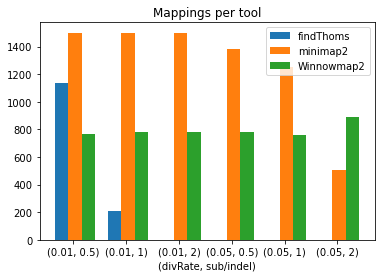

In [200]:
makeX_CategoricalBarPlot(nbMappingsPerTool, "Mappings per tool", "(divRate, sub/indel)")

## Total Mappings for Different Reward Scores
[Back to Contents](#Contents-3)

Reward score: 1
Diversity Rate: 0.01, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.01, substitutions/indel: 1
500 result files found
Diversity Rate: 0.01, substitutions/indel: 2
500 result files found
Diversity Rate: 0.05, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.05, substitutions/indel: 1
500 result files found
Diversity Rate: 0.05, substitutions/indel: 2
500 result files found
Reward score: 5
Diversity Rate: 0.01, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.01, substitutions/indel: 1
500 result files found
Diversity Rate: 0.01, substitutions/indel: 2
500 result files found
Diversity Rate: 0.05, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.05, substitutions/indel: 1
500 result files found
Diversity Rate: 0.05, substitutions/indel: 2
500 result files found
Reward score: 10
Diversity Rate: 0.01, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.01, substitutions/indel: 1
500 result f

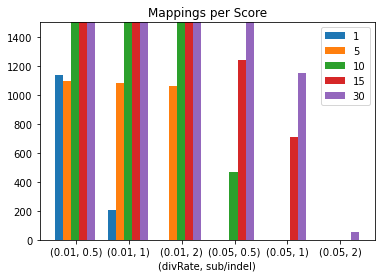

In [232]:
resFilesPerScore = {}
copyScores = [1, 5, 10, 15, 30]
    
for c in copyScores:
    print("Reward score:", c)
    
    resFilesPerScore[c] = {}
    
    for d in divRates:
        for s in subIndelRats:
            dsCombi = f"m{(d * s):.3f}_d{d}_i{d}"
            
            if c == 1:
                filesRegEx = f"../simulations/homologies/homologies_rl400000_rid*_{dsCombi}_cn3_tl50000_chP6C4" + \
                f"_ep0:0:0_ri*_k15_c{c}_*"
            else:
                filesRegEx = f"../simulations/homologies/homologies_rl400000_rid*_{dsCombi}_cn3_tl50000_chP6C4" + \
                f"_ep0:0:0_ri*_c{c}_*"
                
            resFilesPerScore[c][(d, s)] = glob(filesRegEx)
            
            print(f"Diversity Rate: {d}, substitutions/indel: {s}")
            print(f"{len(resFilesPerScore[c][(d, s)])} result files found")

nbMappingsPerScore = {}

for c in copyScores:
    nbMappingsPerScore[c] = {}
    
    for d in divRates:
        for s in subIndelRats:
            nbMappingsPerScore[c][(d, s)] = 0
            
            for f in resFilesPerScore[c][(d, s)]:
                nbMappingsPerScore[c][(d, s)] += len(open(f, 'r').readlines())
                
makeX_CategoricalBarPlot(nbMappingsPerScore, "Mappings per Score", "(divRate, sub/indel)")

## Total Mappings for Different Thresholds
[Back to Contents](#Contents-3)

Threshold: 0
Diversity Rate: 0.01, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.01, substitutions/indel: 1
500 result files found
Diversity Rate: 0.01, substitutions/indel: 2
500 result files found
Diversity Rate: 0.05, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.05, substitutions/indel: 1
500 result files found
Diversity Rate: 0.05, substitutions/indel: 2
500 result files found
Threshold: -1000
Diversity Rate: 0.01, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.01, substitutions/indel: 1
500 result files found
Diversity Rate: 0.01, substitutions/indel: 2
500 result files found
Diversity Rate: 0.05, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.05, substitutions/indel: 1
500 result files found
Diversity Rate: 0.05, substitutions/indel: 2
500 result files found
Threshold: -2000
Diversity Rate: 0.01, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.01, substitutions/indel: 1
500 result fil

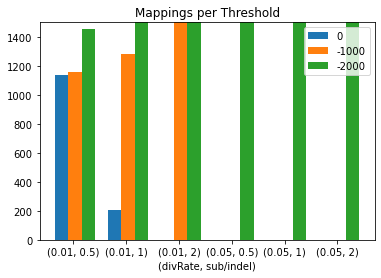

In [227]:
resFilesPerThres = {}
thresholds = [0, -1000, -2000, -19999]
    
for t in thresholds:
    print("Threshold:", t)
    
    resFilesPerThres[t] = {}
    
    for d in divRates:
        for s in subIndelRats:
            dsCombi = f"m{(d * s):.3f}_d{d}_i{d}"
            
            if t == 0:
                fileRegEx = f"../simulations/homologies/homologies_rl400000_rid*_{dsCombi}_cn3_tl50000_chP6C4" + \
                f"_ep0:0:0_ri*_k15_*_t{t}*"
            else:
                fileRegEx = f"../simulations/homologies/homologies_rl400000_rid*_{dsCombi}_cn3_tl50000_chP6C4" + \
                f"_ep0:0:0_ri*_t{t}*"
                
            resFilesPerThres[t][(d, s)] = glob(fileRegEx)
            
            print(f"Diversity Rate: {d}, substitutions/indel: {s}")
            print(f"{len(resFilesPerThres[t][(d, s)])} result files found")

nbMappingsPerThreshold = {}

for t in thresholds:
    nbMappingsPerThreshold[t] = {}
    
    for d in divRates:
        for s in subIndelRats:
            nbMappingsPerThreshold[t][(d, s)] = 0
            
            for f in resFilesPerThres[t][(d, s)]:
                nbMappingsPerThreshold[t][(d, s)] += len(open(f, 'r').readlines())
                
makeX_CategoricalBarPlot(nbMappingsPerThreshold, "Mappings per Threshold", "(divRate, sub/indel)")

## Total Mappings for Different $k$-mer sizes
[Back to Contents](#Contents-3)

In [361]:
def countTotalMappings(resFilesPerCategory):
    nbMappingsPerCategory = {}
    
    for c in resFilesPerCategory.keys():
        nbMappingsPerCategory[c] = {}
        
        for d in divRates:
            for s in subIndelRats:
                nbMappingsPerCategory[c][(d, s)] = 0
            
                for f in resFilesPerCategory[c][(d, s)]:
                    nbMappingsPerCategory[c][(d, s)] += len(open(f, 'r').readlines())
                    
    return nbMappingsPerCategory

k: 9
Diversity Rate: 0.01, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.01, substitutions/indel: 1
500 result files found
Diversity Rate: 0.01, substitutions/indel: 2
500 result files found
Diversity Rate: 0.05, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.05, substitutions/indel: 1
500 result files found
Diversity Rate: 0.05, substitutions/indel: 2
500 result files found
k: 12
Diversity Rate: 0.01, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.01, substitutions/indel: 1
500 result files found
Diversity Rate: 0.01, substitutions/indel: 2
500 result files found
Diversity Rate: 0.05, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.05, substitutions/indel: 1
500 result files found
Diversity Rate: 0.05, substitutions/indel: 2
500 result files found
k: 15
Diversity Rate: 0.01, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.01, substitutions/indel: 1
500 result files found
Diversity Rate: 0.01,

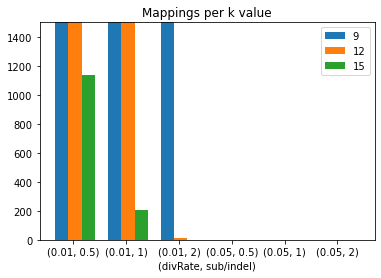

In [327]:
resFilesPerK = {}
ks = [9, 12, 15]
    
for k in ks:
    print("k:", k)
    
    resFilesPerK[k] = {}
    
    for d in divRates:
        for s in subIndelRats:
            dsCombi = f"m{(d * s):.3f}_d{d}_i{d}"
            
            fileRegEx = f"../simulations/homologies/homologies_rl400000_rid*_{dsCombi}_cn3_tl50000_chP6C4" + \
            f"_ep0:0:0_ri*_k{k}_c1_u1_t0.txt"
                
            resFilesPerK[k][(d, s)] = glob(fileRegEx)
            
            print(f"Diversity Rate: {d}, substitutions/indel: {s}")
            print(f"{len(resFilesPerK[k][(d, s)])} result files found")

makeX_CategoricalBarPlot(countTotalMappings(resFilesPerK), "Mappings per k value", "(divRate, sub/indel)", True)

## Total Mappings Based on Confidence Interval Thresholds
[Back to Contents](#Contents-3)

findThoms:
Diversity Rate: 0.01, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.01, substitutions/indel: 1
500 result files found
Diversity Rate: 0.01, substitutions/indel: 2
500 result files found
Diversity Rate: 0.05, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.05, substitutions/indel: 1
500 result files found
Diversity Rate: 0.05, substitutions/indel: 2
500 result files found
minimap2:
Diversity Rate: 0.01, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.01, substitutions/indel: 1
500 result files found
Diversity Rate: 0.01, substitutions/indel: 2
500 result files found
Diversity Rate: 0.05, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.05, substitutions/indel: 1
500 result files found
Diversity Rate: 0.05, substitutions/indel: 2
500 result files found
Winnowmap2:
Diversity Rate: 0.01, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.01, substitutions/indel: 1
500 result files found
Diver

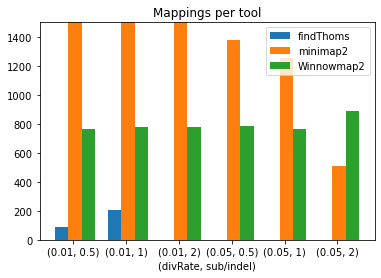

In [382]:
resFilesForAdaptThres = searchMappingRes(resultPrefixPerTool, divRates, subIndelRats, 15, 1, -19999)

In [439]:
mappingsPerToolWthAdaptThres = countMappingsPerTool(resFilesForAdaptThres, oSidConfBord)

findThoms:
Diversity Rate: 0.01, substitutions/indel: 0.5
1069 mappings found
Diversity Rate: 0.01, substitutions/indel: 1
1191 mappings found
Diversity Rate: 0.01, substitutions/indel: 2
1466 mappings found
Diversity Rate: 0.05, substitutions/indel: 0.5
5492202 mappings found
Diversity Rate: 0.05, substitutions/indel: 1
4620442 mappings found
Diversity Rate: 0.05, substitutions/indel: 2
1595074 mappings found
minimap2:
Diversity Rate: 0.01, substitutions/indel: 0.5
1500 mappings found
Diversity Rate: 0.01, substitutions/indel: 1
1500 mappings found
Diversity Rate: 0.01, substitutions/indel: 2
1500 mappings found
Diversity Rate: 0.05, substitutions/indel: 0.5
1380 mappings found
Diversity Rate: 0.05, substitutions/indel: 1
1251 mappings found
Diversity Rate: 0.05, substitutions/indel: 2
509 mappings found
Winnowmap2:
Diversity Rate: 0.01, substitutions/indel: 0.5
763 mappings found
Diversity Rate: 0.01, substitutions/indel: 1
779 mappings found
Diversity Rate: 0.01, substitutions/indel

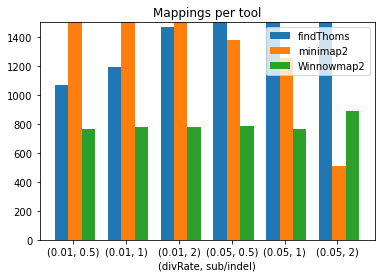

In [440]:
makeX_CategoricalBarPlot(mappingsPerToolWthAdaptThres, "Mappings per tool", "(divRate, sub/indel)", True)

## Number of Mapped Reads
[Back to Contents](#Contents-3)

In [194]:
from os.path import getsize

nbMappedReadsPerTool = {}

for t in resFilesPerTool.keys():
    nbMappedReadsPerTool[t] = {}
    
    for d in divRates:
        for s in subIndelRats:
            nbMappedReads = 0
            
            for f in resFilesPerTool[t][(d, s)]:
                #Every not empty result file means a successfully mapped read
                if t == "findThoms" and getsize(f) > 0:
                    nbMappedReads += 1
                else:
                    for m in loadSam(f):
                        if not "isUnaligned" in m:
                            nbMappedReads += 1
                            break
                            
            nbMappedReadsPerTool[t][(d, s)] = nbMappedReads

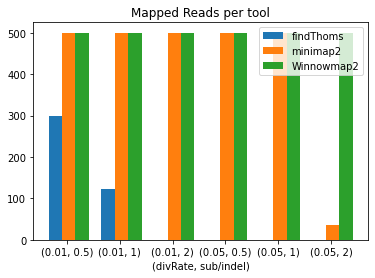

In [201]:
makeX_CategoricalBarPlot(nbMappedReadsPerTool, "Mapped Reads per tool", "(divRate, sub/indel)")

## Number of Mapped Reads for Different Reward Scores
[Back to Contents](#Contents-3)

In [399]:
def countNonEmptyFiles(resFiles, scoThres):
    nbMappedReads = {}
    
    for c in resFiles.keys():
        nbMappedReads[c] = {}
        
        for d in divRates:
            for s in subIndelRats:
                n = 0
            
                for f in resFiles[c][(d, s)]:
                    if "findThoms" in resFiles and c != "findThoms":
                        for m in loadSam(f):
                            if not "isUnaligned" in m:
                                n += 1
                                break
                    else:
                        for l in open(f, 'r'):
                            if int(l.split(' ')[-1]) >= scoThres[(d, s)]:
                                n += 1
                                break
                            
                nbMappedReads[c][(d, s)] = n
                
    return nbMappedReads

In [247]:
nbMappedReadsPerScore = countNonEmptyFiles(resFilesPerScore)

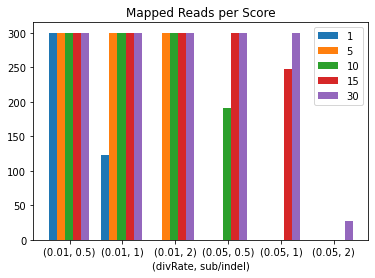

In [248]:
makeX_CategoricalBarPlot(nbMappedReadsPerScore, "Mapped Reads per Score", "(divRate, sub/indel)", False)

## Number of Mapped Reads for Different Thresholds
[Back to Contents](#Contents-3)

In [249]:
nbMappedReadsPerThreshold = countNonEmptyFiles(resFilesPerThres)

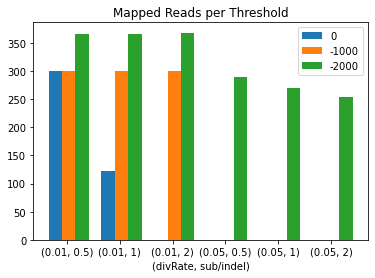

In [250]:
makeX_CategoricalBarPlot(nbMappedReadsPerThreshold, "Mapped Reads per Threshold", "(divRate, sub/indel)", False)

## Number of Mapped Reads for Different Values of $k$
[Back to Contents](#Contents-3)

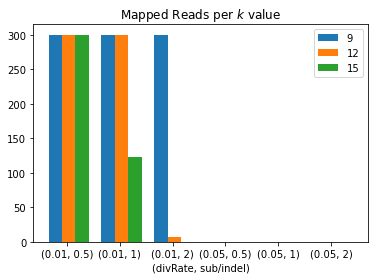

In [328]:
nbMappedReadsPerK = countNonEmptyFiles(resFilesPerK)
makeX_CategoricalBarPlot(nbMappedReadsPerK, r"Mapped Reads per $k$ value", "(divRate, sub/indel)", False)

## Number of Mapped Reads for Adapted Thresholds
[Back to Contents](#Contents-3)

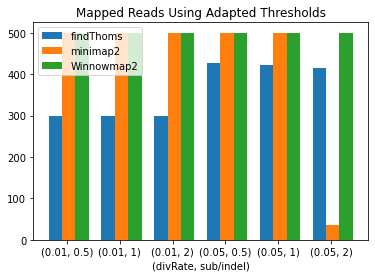

In [441]:
nbMappedReadsForAdpThres = countNonEmptyFiles(resFilesForAdaptThres, oSidConfBord)
title = "Mapped Reads Using Adapted Thresholds"
makeX_CategoricalBarPlot(nbMappedReadsForAdpThres, title, "(divRate, sub/indel)", False)

## Length of Longest Mappings per Read
[Back to Contents](#Contents-3)

In [120]:
import gzip

def loadSam(filename):
    mappings = []
    cnt = 0
    
    if filename.endswith(".gz"):
        filehandle = gzip.open(filename, 'rt')
    else:
        filehandle = open(filename, 'r')
        
    for l in filehandle:
        #We are not interested in header lines
        if l.startswith('@'):
            continue

        cnt += 1
        elems = l.split('\t')
        elems[1] = int(elems[1])
        mappings.append({"id": elems[0]})
        
        #We have a supplementary alignment
        if elems[1] >= 2048:
            elems[1] -= 2048
            mappings[-1]["isSupplementary"] = True
            
        #The read was flagged as a duplicate
        if elems[1] >= 1024:
            elems[1] -= 1024
            mappings[-1]["isDuplicate"] = True
            
            print(f"WARNING: Line {cnt} in SAM file {filename} says that a read is flagged as a duplicate")
            
        #A read failed the quality check
        if elems[1] >= 512:
            elems[1] -= 512
            mappings[-1]["qualityCheckFailed"] = True
            
            print(f"WARNING: Read refered to in Line {cnt} failed the quality check")
            
        #The given alignment is secondary
        if elems[1] >= 256:
            elems[1] -= 256
            mappings[-1]["isSecundary"] = True
            
        #We have found the second mate of a read pair
        if elems[1] >= 128:
            elems[1] -= 128
            mappings[-1]["isSecondReadPairMate"] = True
            
            print(f"WARNING: In Line {cnt}, we have found the second mate of a read pair")
            
        #We have found the first mate of a read pair
        if elems[1] >= 64:
            elems[1] -= 64
            mappings[-1]["isFirstReadPairMate"] = True
            
            print(f"WARNING: In Line {cnt}, we have found the first mate of a read pair")
            
        #Mate of this guy aligned in reverse direction
        if elems[1] >= 32:
            elems[1] -= 32
            mappings[-1]["hasReverselyAlignedMate"] = True
            
            print(f"WARNING: In Line {cnt}, we have found a mate who's other mate aligned in reverse direction")
            
        #Read aligned in reverse direction
        if elems[1] >= 16:
            elems[1] -= 16
            mappings[-1]["mappedReversely"] = True
            
        #Read is part of pair and mate was not aligned
        if elems[1] >= 8:
            elems[1] -= 8
            mappings[-1]["mateUnaligned"] = True
            
            print(f"WARNING: In Line {cnt}, we consider a read whose mate was not aligned")
            
        #Read could not be aligned
        if elems[1] >= 4:
            elems[1] -= 4
            mappings[-1]["isUnaligned"] = True
            
        #Read is part of properly aligned pair
        if elems[1] >= 2:
            elems[1] -= 2
            mappings[-1]["belongsToProperlyAlignedReadPair"] = True
            
            print(f"WARNING: The read considered in Line {cnt} belongs to a properly aligned read pair")
            
        #Read is paired
        if elems[1] >= 1:
            elems[1] -= 1
            mappings[-1]["isPaired"] = True
            
            print(f"WARNING: The read considered in Line {cnt} belongs to a pair")
            
        #If a read is unaligned, we cannot get any further infos at this point
        if "isUnaligned" in mappings[-1]:
            continue
            
        #Calculate end position of mapping
        mappings[-1]["start"] = int(elems[3])
        end = mappings[-1]["start"] - 1
        nbOps = ""
        
        for c in elems[5]:
            if c.isdigit():
                nbOps += c
            #Run of matches found
            elif c == 'M' or 'D' or 'N' or '=' or 'X':
                #Testing
                #if filename == "../simulations/minimap2Res/textmappings_rl400000_rid58_m0.100_d0.05_i0.05_cn3" + \
                #"_tl50000_chP6C4_ep0:0:0_ri1.sam":
                #    print("nbOps:", nbOps)
                
                end += int(nbOps)
                nbOps = ""
            elif c == 'I' or 'S' or 'H' or 'P':
                nbOps = ""
            else:
                print(f"ERROR: Unrecognized operation {c} detected in CIGAR string in Line {cnt}")
                
        mappings[-1]["end"] = end
        
    return mappings

findThoms:
Diversity Rate: 0.01, substitutions/indel: 0.5


<Figure size 432x288 with 0 Axes>

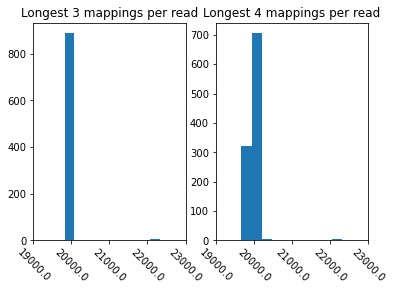

Diversity Rate: 0.01, substitutions/indel: 1


<Figure size 432x288 with 0 Axes>

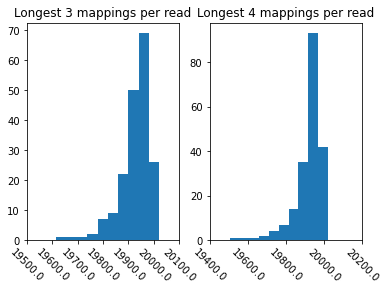

Diversity Rate: 0.01, substitutions/indel: 2
No mappings found!
Diversity Rate: 0.05, substitutions/indel: 0.5
No mappings found!
Diversity Rate: 0.05, substitutions/indel: 1
No mappings found!
Diversity Rate: 0.05, substitutions/indel: 2
No mappings found!
minimap2:
Diversity Rate: 0.01, substitutions/indel: 0.5


<Figure size 432x288 with 0 Axes>

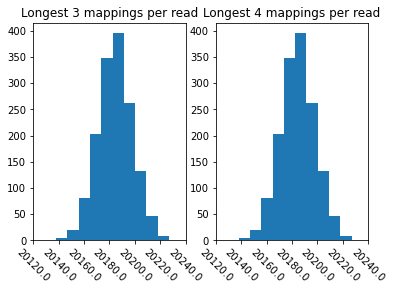

Diversity Rate: 0.01, substitutions/indel: 1


<Figure size 432x288 with 0 Axes>

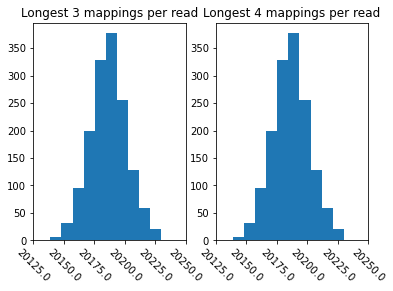

Diversity Rate: 0.01, substitutions/indel: 2


<Figure size 432x288 with 0 Axes>

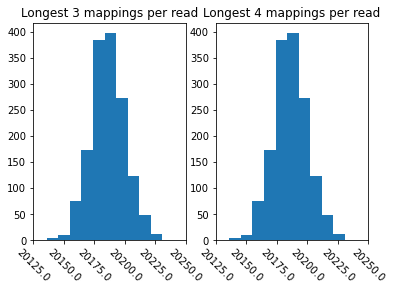

Diversity Rate: 0.05, substitutions/indel: 0.5


<Figure size 432x288 with 0 Axes>

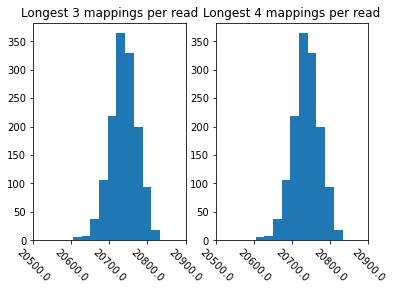

Diversity Rate: 0.05, substitutions/indel: 1


<Figure size 432x288 with 0 Axes>

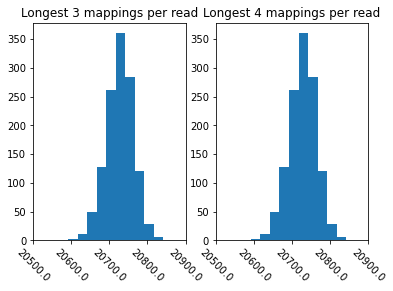

Diversity Rate: 0.05, substitutions/indel: 2


<Figure size 432x288 with 0 Axes>

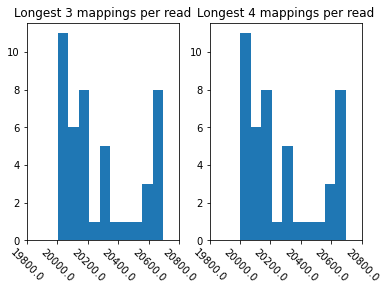

Winnowmap2:
Diversity Rate: 0.01, substitutions/indel: 0.5


<Figure size 432x288 with 0 Axes>

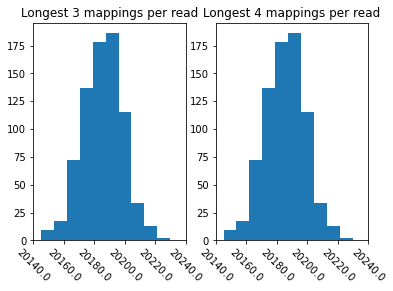

Diversity Rate: 0.01, substitutions/indel: 1


<Figure size 432x288 with 0 Axes>

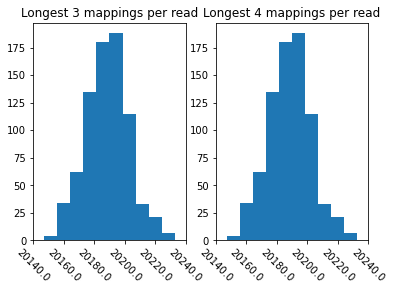

Diversity Rate: 0.01, substitutions/indel: 2


<Figure size 432x288 with 0 Axes>

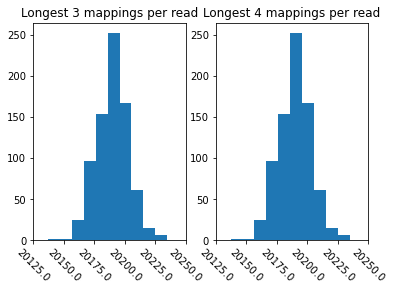

Diversity Rate: 0.05, substitutions/indel: 0.5


<Figure size 432x288 with 0 Axes>

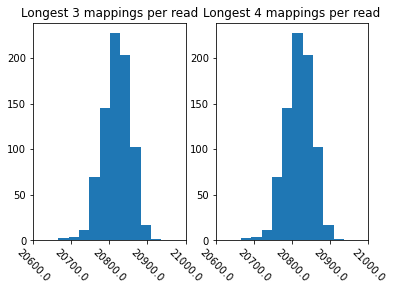

Diversity Rate: 0.05, substitutions/indel: 1


<Figure size 432x288 with 0 Axes>

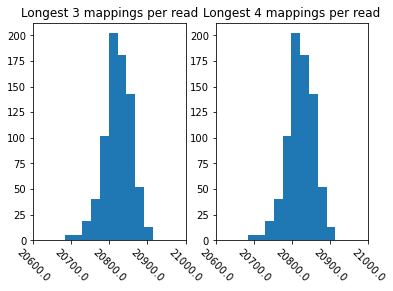

Diversity Rate: 0.05, substitutions/indel: 2


<Figure size 432x288 with 0 Axes>

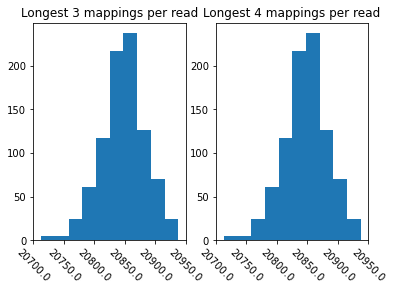

In [163]:
from math import floor

#How many mappings per read are we interested in?
nMappings = 4

for t in resFilesPerTool.keys():
    print(f"{t}:")
    
    for d in divRates:
        for s in subIndelRats:
            print(f"Diversity Rate: {d}, substitutions/indel: {s}")
            
            allLongestMappings = []
            
            for f in resFilesPerTool[t][(d, s)]:
                longestMappings = []
                
                if t == "findThoms":
                    mappingLens = []
                    tId = f.split('homologies_rl')[1].split('_tl50000')[0]
                    tFile = open(f"../simulations/text_rl{tId}.fasta", 'r')
                    tSeq = str([r for r in SeqIO.parse(tFile, "fasta")][0].seq)
                    tSketch = calcSketch(tSeq, 15, floor(((4 ** 15) - 1) * 0.1))
                    
                    for l in open(f, 'r'):
                        elems = l.split(' ')
                        
                        #Testing
                        #print("tSeq:", tSeq)
                        #print("elems[3]:", elems[3])
                        #print("elems[1]:", elems[1])
                        #print("tSketch:", tSketch)
                        
                        mappingLens.append(tSketch[int(elems[3])][0] - tSketch[int(elems[1])][0] + 1)
                else:
                    mappingLens = [m["end"] - m["start"] + 1 for m in loadSam(f) if not "isUnaligned" in m]
                    
                for l in mappingLens:
                    #Add mapping length if we have not seen enough yet
                    if len(longestMappings) < nMappings:
                        longestMappings.append(l)
                    else:
                        minLen = min(longestMappings)
                        
                        if minLen < l:
                            longestMappings.remove(minLen)
                            longestMappings.append(l)
                            
                if len(longestMappings) > 0:
                    allLongestMappings.append(list(longestMappings))
                
            if len(allLongestMappings) > 0:
                plt.figure()
                fig, axes = plt.subplots(1, 2)
                axes[0].hist([l for lst in allLongestMappings for l in lst if len(lst) < nMappings or l != \
                              min(lst)])
                axes[1].hist([l for lst in allLongestMappings for l in lst])
                axes[0].set_title("Longest 3 mappings per read")
                axes[1].set_title("Longest 4 mappings per read")
                axes[0].set_xticks(axes[0].get_xticks())
                axes[1].set_xticks(axes[1].get_xticks())
                axes[0].set_xticklabels(axes[0].get_xticks(), rotation = -45)
                axes[1].set_xticklabels(axes[1].get_xticks(), rotation = -45)
                plt.show()
            else:
                print("No mappings found!")

### Homology Threshold $\alpha=-2000$
[Back to Contents](#Contents-3)

Diversity Rate: 0.01, substitutions/indel: 0.5


<Figure size 432x288 with 0 Axes>

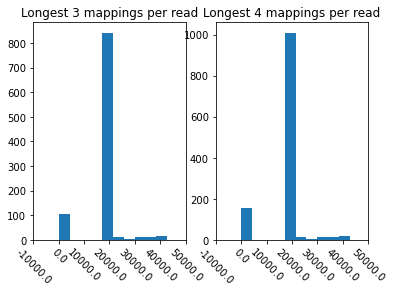

Diversity Rate: 0.01, substitutions/indel: 1


<Figure size 432x288 with 0 Axes>

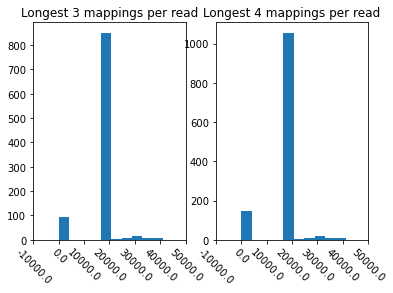

Diversity Rate: 0.01, substitutions/indel: 2


<Figure size 432x288 with 0 Axes>

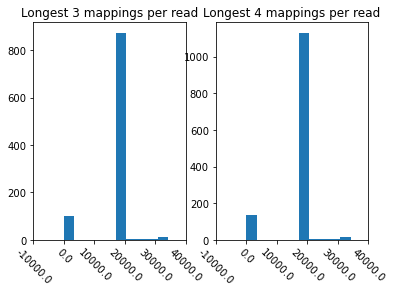

Diversity Rate: 0.05, substitutions/indel: 0.5


<Figure size 432x288 with 0 Axes>

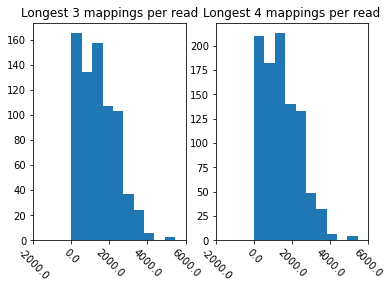

Diversity Rate: 0.05, substitutions/indel: 1


<Figure size 432x288 with 0 Axes>

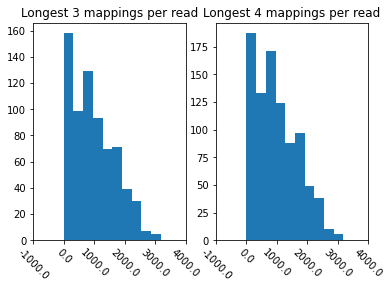

Diversity Rate: 0.05, substitutions/indel: 2


<Figure size 432x288 with 0 Axes>

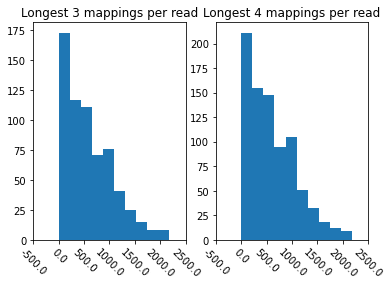

In [258]:
#How many mappings per read are we interested in?
nMappings = 4

for d in divRates:
    for s in subIndelRats:
        print(f"Diversity Rate: {d}, substitutions/indel: {s}")
            
        allLongestMappings = []
        regEx = f"../simulations/homologies/homologies_rl400000_rid*_m{(d * s):.3f}_d{d}_i{d}_cn3_tl50000_" + \
        "chP6C4_ep0:0:0_ri*_c1_u1_t-2000.txt"
            
        for f in glob(regEx):
            longestMappings = []
            mappingLens = []
            tId = f.split('homologies_rl')[1].split('_tl50000')[0]
            tFile = open(f"../simulations/text_rl{tId}.fasta", 'r')
            tSeq = str([r for r in SeqIO.parse(tFile, "fasta")][0].seq)
            tSketch = calcSketch(tSeq, 15, floor(((4 ** 15) - 1) * 0.1))
                    
            for l in open(f, 'r'):
                elems = l.split(' ')
                mappingLens.append(tSketch[int(elems[3])][0] - tSketch[int(elems[1])][0] + 1)
                
            for l in mappingLens:
                #Add mapping length if we have not seen enough yet
                if len(longestMappings) < nMappings:
                    longestMappings.append(l)
                else:
                    minLen = min(longestMappings)
                        
                    if minLen < l:
                        longestMappings.remove(minLen)
                        longestMappings.append(l)
                            
            if len(longestMappings) > 0:
                allLongestMappings.append(list(longestMappings))
                
        if len(allLongestMappings) > 0:
            plt.figure()
            fig, axes = plt.subplots(1, 2)
            axes[0].hist([l for lst in allLongestMappings for l in lst if len(lst) < nMappings or l != min(lst)])
            axes[1].hist([l for lst in allLongestMappings for l in lst])
            axes[0].set_title("Longest 3 mappings per read")
            axes[1].set_title("Longest 4 mappings per read")
            axes[0].set_xticks(axes[0].get_xticks())
            axes[1].set_xticks(axes[1].get_xticks())
            axes[0].set_xticklabels(axes[0].get_xticks(), rotation = -45)
            axes[1].set_xticklabels(axes[1].get_xticks(), rotation = -45)
            plt.show()
        else:
            print("No mappings found!")

### $k=9$
[Back to Contents](#Contents-3)

Diversity Rate: 0.01, substitutions/indel: 0.5


<Figure size 432x288 with 0 Axes>

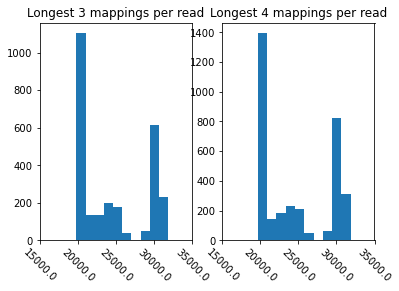

Diversity Rate: 0.01, substitutions/indel: 1


<Figure size 432x288 with 0 Axes>

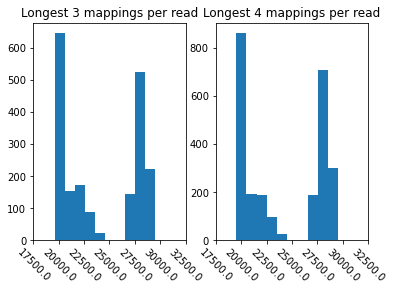

Diversity Rate: 0.01, substitutions/indel: 2


<Figure size 432x288 with 0 Axes>

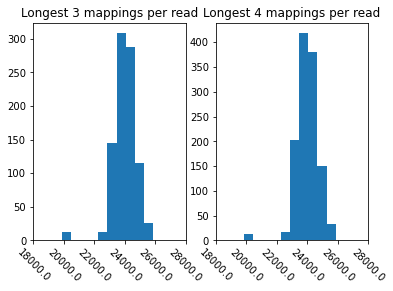

Diversity Rate: 0.05, substitutions/indel: 0.5
No mappings found!
Diversity Rate: 0.05, substitutions/indel: 1
No mappings found!
Diversity Rate: 0.05, substitutions/indel: 2
No mappings found!


In [329]:
def plotLongestMappingsLengthsPerRead(fileRegExWithSubAndIndelRatsWildcards):
    #How many mappings per read are we interested in?
    nMappings = 4
    
    for d in divRates:
        for s in subIndelRats:
            print(f"Diversity Rate: {d}, substitutions/indel: {s}")
            
            allLongestMappings = []
            regEx = fileRegExWithSubAndIndelRatsWildcards.replace("SUBSWC", f"{(d * s):.3f}")
            regEx = regEx.replace("DELSWC", f"{d}").replace("INSWC", f"{d}")
            
            for f in glob(regEx):
                longestMappings = []
                mappingLens = []
                tId = f.split('homologies_rl')[1].split('_tl50000')[0]
                tFile = open(f"../simulations/text_rl{tId}.fasta", 'r')
                tSeq = str([r for r in SeqIO.parse(tFile, "fasta")][0].seq)
                k = int(f.split("_k")[1].split("_c1")[0])
                tSketch = calcSketch(tSeq, k, floor(((4 ** k) - 1) * 0.1))
                    
                for l in open(f, 'r'):
                    elems = l.split(' ')
                    mappingLens.append(tSketch[int(elems[3])][0] - tSketch[int(elems[1])][0] + 1)
                
                for l in mappingLens:
                    #Add mapping length if we have not seen enough yet
                    if len(longestMappings) < nMappings:
                        longestMappings.append(l)
                    else:
                        minLen = min(longestMappings)
                        
                        if minLen < l:
                            longestMappings.remove(minLen)
                            longestMappings.append(l)
                            
                if len(longestMappings) > 0:
                    allLongestMappings.append(list(longestMappings))
                
            if len(allLongestMappings) > 0:
                plt.figure()
                fig, axes = plt.subplots(1, 2)
                axes[0].hist([l for lst in allLongestMappings for l in lst if len(lst) < nMappings or l != \
                              min(lst)])
                axes[1].hist([l for lst in allLongestMappings for l in lst])
                axes[0].set_title(f"Longest {nMappings - 1} mappings per read")
                axes[1].set_title(f"Longest {nMappings} mappings per read")
                axes[0].set_xticks(axes[0].get_xticks())
                axes[1].set_xticks(axes[1].get_xticks())
                axes[0].set_xticklabels(axes[0].get_xticks(), rotation = -45, rotation_mode='anchor')
                axes[1].set_xticklabels(axes[1].get_xticks(), rotation = -45, rotation_mode='anchor')
                plt.tight_layout()
                plt.show()
            else:
                print("No mappings found!")
            
plotLongestMappingsLengthsPerRead("../simulations/homologies/homologies_rl400000_rid*_mSUBSWC_dDELSWC_iINSWC" + \
                                  "_cn3_tl50000_chP6C4_ep0:0:0_ri*_k*_c1_u1_t0.txt")

### Adapted Thresholds
[Back to Contents](#Contents-3)

Diversity Rate: 0.01, substitutions/indel: 0.5


<Figure size 432x288 with 0 Axes>

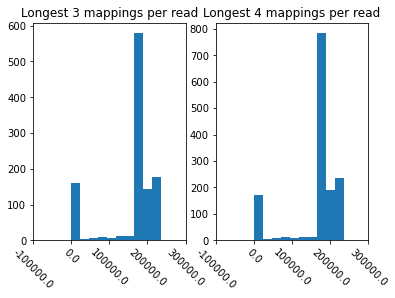

Diversity Rate: 0.01, substitutions/indel: 1


<Figure size 432x288 with 0 Axes>

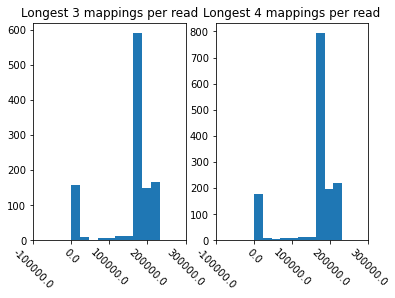

Diversity Rate: 0.01, substitutions/indel: 2


<Figure size 432x288 with 0 Axes>

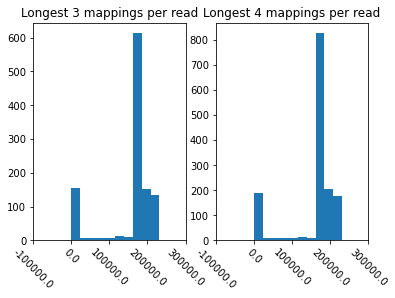

Diversity Rate: 0.05, substitutions/indel: 0.5


<Figure size 432x288 with 0 Axes>

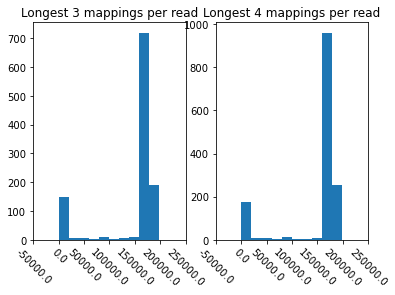

Diversity Rate: 0.05, substitutions/indel: 1


<Figure size 432x288 with 0 Axes>

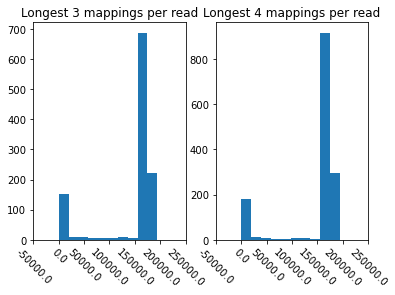

Diversity Rate: 0.05, substitutions/indel: 2


<Figure size 432x288 with 0 Axes>

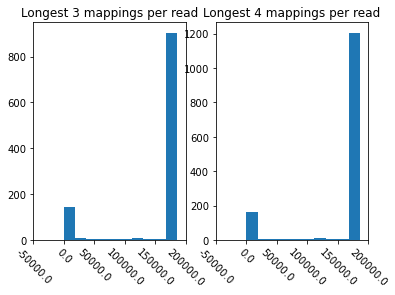

In [442]:
plotLongestMappingsLengthsPerRead("../simulations/homologies/homologies_rl400000_rid*_mSUBSWC_dDELSWC_iINSWC" + \
                                  "_cn3_tl50000_chP6C4_ep0:0:0_ri*_k15_c1_u1_t-19999.txt")

## Average Number of Template Copies a Read was Mapped to
[Back to Contents](#Contents-3)

In [208]:
def checkForOverlaps(start, end, regionsToCheck, foundRegions, nbPartlyOverlappingMappings):
    i = 0
                        
    for c in regionsToCheck:
        if start <= c[0] and end >= c[0] and not foundRegions[i]:
            foundRegions[i] = True
            nbPartlyOverlappingMappings += 1
            return 1
        elif start >= c[0] and end <= c[1] and not foundRegions[i]:
            foundRegions[i] = True
            return 1
        elif start <= c[1] and end >= c[1] and not foundRegions[i]:
            foundRegions[i] = True
            nbPartlyOverlappingMappings += 1
            return 1
                            
        i += 1
        
    return 0
    
#Find template coordinates in texts
templateCoordsPerText = {}

for d in divRates:
    for s in subIndelRats:
        for i in range(100):
            fileHandle = open(f"../simulations/text_rl400000_rid{i}_m{(d * s):.3f}_d{d}_i{d}_cn3.fasta", 'r')
            text = [r for r in SeqIO.parse(fileHandle, "fasta")][0].seq
            templateCoordsPerText[(d, s, i)] = []
            
            for j in range(3):
                fileHandle = open(f"../simulations/randSeqCopy_l50000_rid{i}_m{(d * s):.3f}_d{d}_i{d}_cn{j}.fasta")
                copySeq = [r for r in SeqIO.parse(fileHandle, "fasta")][0].seq
                start = text.find(copySeq)
                templateCoordsPerText[(d, s, i)].append((start, start + len(copySeq) - 1))

textSketches = {}

for d in divRates:
    for s in subIndelRats:
        textSketches[(d, s)] = []
        
        for i in range(100):
            tFile = open(f"../simulations/text_rl400000_rid{i}_m{(d * s):.3f}_d{d}_i{d}_cn3.fasta", 'r')
            tSeq = str([r for r in SeqIO.parse(tFile, "fasta")][0].seq)
            textSketches[(d, s)].append(calcSketch(tSeq, 15, floor(((4 ** 15) - 1) * 0.1)))

In [268]:
nbHitTemplateCopiesPerTool = {}
nbPartlyOverlappingMappings = 0
resFilesPerTool = searchMappingRes(resultPrefixPerTool, divRates, subIndelRats, 15, 1, 0)

for t in resFilesPerTool.keys():
    nbHitTemplateCopiesPerTool[t] = {}
    
    for d in divRates:
        for s in subIndelRats:
            nbHitTemplateCopiesPerTool[t][(d, s)] = []
            
            for f in resFilesPerTool[t][(d, s)]:
                nbHitTemplateCopiesPerTool[t][(d, s)].append(0)
                copiesFound = [False, False, False]
                
                if t == "findThoms":
                    rid = int(f.split("_rid")[1].split("_m")[0])
                    
                    for l in open(f, 'r'):
                        elems = l.split(' ')
                        start = tSketch[int(elems[1])][0]
                        end = tSketch[int(elems[3])][0]
                        nbHitTemplateCopiesPerTool[t][(d, s)][-1] += checkForOverlaps(start, end, \
                         templateCoordsPerText[(d, s, rid)], copiesFound, nbPartlyOverlappingMappings)
                else:
                    mappings = [m for m in loadSam(f) if not "isUnaligned" in m]
                    
                    for m in mappings:
                        nbHitTemplateCopiesPerTool[t][(d, s)][-1] += checkForOverlaps(m["start"], m["end"], \
                         templateCoordsPerText[(d, s, rid)], copiesFound, nbPartlyOverlappingMappings)

findThoms:
Diversity Rate: 0.01, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.01, substitutions/indel: 1
500 result files found
Diversity Rate: 0.01, substitutions/indel: 2
500 result files found
Diversity Rate: 0.05, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.05, substitutions/indel: 1
500 result files found
Diversity Rate: 0.05, substitutions/indel: 2
500 result files found
minimap2:
Diversity Rate: 0.01, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.01, substitutions/indel: 1
500 result files found
Diversity Rate: 0.01, substitutions/indel: 2
500 result files found
Diversity Rate: 0.05, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.05, substitutions/indel: 1
500 result files found
Diversity Rate: 0.05, substitutions/indel: 2
500 result files found
Winnowmap2:
Diversity Rate: 0.01, substitutions/indel: 0.5
500 result files found
Diversity Rate: 0.01, substitutions/indel: 1
500 result files found
Diver

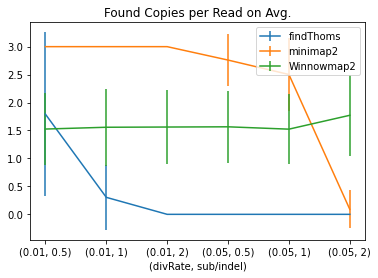

In [270]:
from numpy import std

def plotAvgFoundCopies(data):
    plt.figure()

    for c in data:
        xVals = range(len(data[c]))
        means = [mean(data[c][n]) for n in data[c]]
        stds = [std(data[c][n]) for n in data[c]]
        plt.errorbar(xVals, means, yerr=stds, label=c)

    for k in data:
        someKey = k
        break
        
    plt.xticks(xVals, data[someKey].keys())
    plt.title("Found Copies per Read on Avg.")
    plt.xlabel("(divRate, sub/indel)")
    plt.legend()
    plt.show()

plotAvgFoundCopies(nbHitTemplateCopiesPerTool)

### For Different Reward Scores
[Back to Contents](#Contents-3)

In [404]:
def countTemplateCopyHits(resFiles, thresPerDiv):
    nbHitTemplateCopiesPerCategory = {}
    nbPartlyOverlappingMappings = 0

    for c in resFiles.keys():
        nbHitTemplateCopiesPerCategory[c] = {}
    
        for d in divRates:
            for s in subIndelRats:
                nbHitTemplateCopiesPerCategory[c][(d, s)] = []
            
                for f in resFiles[c][(d, s)]:
                    nbHitTemplateCopiesPerCategory[c][(d, s)].append(0)
                    copiesFound = [False, False, False]
                    rid = int(f.split("_rid")[1].split("_m")[0])
                    
                    if "findThoms" in resFiles and c != "findThoms":
                        mappings = [m for m in loadSam(f) if not "isUnaligned" in m]
                    
                        for m in mappings:
                            nbHitTemplateCopiesPerCategory[c][(d, s)][-1] += checkForOverlaps(m["start"], \
                             m["end"], templateCoordsPerText[(d, s, rid)], copiesFound, nbPartlyOverlappingMappings)
                    else:
                        for l in open(f, 'r'):
                            elems = l.split(' ')
                            if int(elems[-1]) >= thresPerDiv[(d, s)]:
                                start = tSketch[int(elems[1])][0]
                                end = tSketch[int(elems[3])][0]
                                nbHitTemplateCopiesPerCategory[c][(d, s)][-1] += checkForOverlaps(start, end, \
                                    templateCoordsPerText[(d, s, rid)], copiesFound, nbPartlyOverlappingMappings)

    print(f"{nbPartlyOverlappingMappings} mappings are overlapping partly")
    
    return nbHitTemplateCopiesPerCategory

0 mappings are overlapping partly


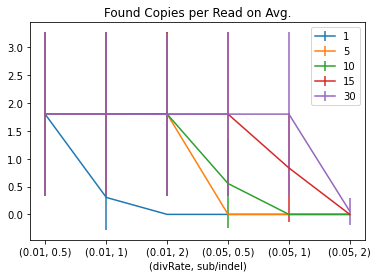

In [403]:
plotAvgFoundCopies(countTemplateCopyHits(resFilesPerScore))

### For Different Thresholds
[Back to Contents](#Contents-3)

0 mappings are overlapping partly


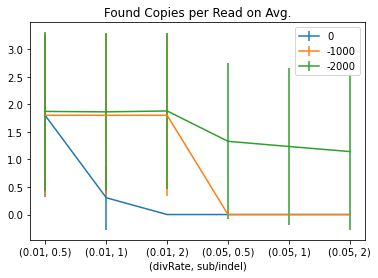

In [275]:
plotAvgFoundCopies(countTemplateCopyHits(resFilesPerThres))

### For Different Values of $k$
[Back to Contents](#Contents-3)

0 mappings are overlapping partly


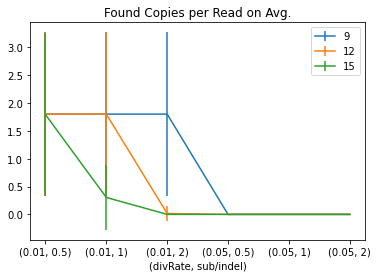

In [331]:
plotAvgFoundCopies(countTemplateCopyHits(resFilesPerK))

### For Adapted Thresholds
[Back to Contents](#Contents-3)

0 mappings are overlapping partly


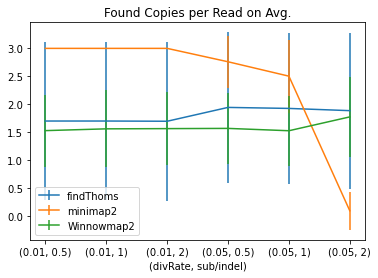

In [443]:
plotAvgFoundCopies(countTemplateCopyHits(resFilesForAdaptThres, oSidConfBord))

## Runtime and Memory
[Back to Contents](#Simulation-Run-3:-FindThoms-(C++)-vs.-minimap2-vs.-Winnowmap2)

In [83]:
#This function takes a list of benchmark file names and returns a dictionary containing all run times and max memory
#usages
def loadBenchmarks(fileList):
    benchmarks = {"rt": [], "mem": []}
    
    for f in fileList:
        for l in open(f, 'r'):
            if l.find("User") > -1:
                benchmarks["rt"].append(float(l.split(':')[1]))
            
            if l.find("Maximum") > -1:
                benchmarks["mem"].append(int(l.split(':')[1]))
                break
                
    return benchmarks

In [90]:
from numpy import mean

#Load benchmarks
tools = ["FindThoms", "Minimap2", "Winnowmap2"]
divRates = [0.01, 0.05]
subIndelRats = [0.5, 1, 2]
allToolsBenchs = {}

for t in tools:
    allToolsBenchs[t] = {}
    
    for d in divRates:
        for s in subIndelRats:
            dsCombi = f"m{(d * s):.3f}_d{d}_i{d}"
            
            if t == "FindThoms":
                indivBenchs = loadBenchmarks(glob(f"../benchmarks/bench{t}_rl400000_rid*_" + dsCombi + \
                                              "_cn3_tl50000_chP6C4_ep0:0:0_ri*_c1_u1_t0.txt"))
            else:
                indivBenchs = loadBenchmarks(glob(f"../benchmarks/bench{t}_rl400000_rid*_" + dsCombi + \
                                              "_cn3_tl50000_chP6C4_ep0:0:0_ri*.txt"))
            
            #Sanity check: 500 benchmarks should have been loaded
            print(f"Tool: {t} dsCombi: {dsCombi}")
            print(f"Loaded {len(indivBenchs['rt'])} benchmarks")
            
            allToolsBenchs[t][dsCombi] = {"rt": mean(indivBenchs["rt"]), "mem": mean(indivBenchs["mem"])}

Tool: FindThoms dsCombi: m0.005_d0.01_i0.01
Loaded 500 benchmarks
Tool: FindThoms dsCombi: m0.010_d0.01_i0.01
Loaded 500 benchmarks
Tool: FindThoms dsCombi: m0.020_d0.01_i0.01
Loaded 500 benchmarks
Tool: FindThoms dsCombi: m0.025_d0.05_i0.05
Loaded 500 benchmarks
Tool: FindThoms dsCombi: m0.050_d0.05_i0.05
Loaded 500 benchmarks
Tool: FindThoms dsCombi: m0.100_d0.05_i0.05
Loaded 500 benchmarks
Tool: Minimap2 dsCombi: m0.005_d0.01_i0.01
Loaded 500 benchmarks
Tool: Minimap2 dsCombi: m0.010_d0.01_i0.01
Loaded 500 benchmarks
Tool: Minimap2 dsCombi: m0.020_d0.01_i0.01
Loaded 500 benchmarks
Tool: Minimap2 dsCombi: m0.025_d0.05_i0.05
Loaded 500 benchmarks
Tool: Minimap2 dsCombi: m0.050_d0.05_i0.05
Loaded 500 benchmarks
Tool: Minimap2 dsCombi: m0.100_d0.05_i0.05
Loaded 500 benchmarks
Tool: Winnowmap2 dsCombi: m0.005_d0.01_i0.01
Loaded 500 benchmarks
Tool: Winnowmap2 dsCombi: m0.010_d0.01_i0.01
Loaded 500 benchmarks
Tool: Winnowmap2 dsCombi: m0.020_d0.01_i0.01
Loaded 500 benchmarks
Tool: Winnowm

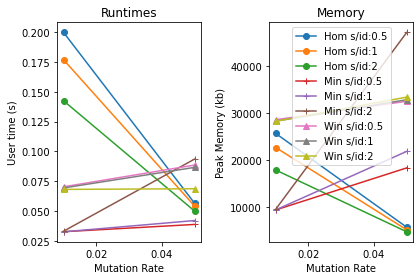

In [93]:
#Plot benchmarks
lineStylePerTool = {"FindThoms": "o-", "Minimap2": "+-", "Winnowmap2": "^-"}
labelShortcutsPerTool = {"FindThoms": "Hom", "Minimap2": "Min", "Winnowmap2": "Win"}
fig, axes = plt.subplots(1, 2)

for t in allToolsBenchs:
    for q in subIndelRats:
        rts = []
        mems = []
        
        for d in divRates:
            dsCombi = f"m{(d * q):.3f}_d{d}_i{d}"
            rts.append(allToolsBenchs[t][dsCombi]["rt"])
            mems.append(allToolsBenchs[t][dsCombi]["mem"])
            
        axes[0].plot(divRates, rts, lineStylePerTool[t], label=f"{labelShortcutsPerTool[t]} s/id:{q}")
        axes[1].plot(divRates, mems, lineStylePerTool[t], label=f"{labelShortcutsPerTool[t]} s/id:{q}")

axes[0].set_title("Runtimes")
axes[0].set_xlabel("Mutation Rate")
axes[0].set_ylabel("User time (s)")
axes[1].set_title("Memory")
axes[1].set_xlabel("Mutation Rate")
axes[1].set_ylabel("Peak Memory (kb)")
axes[1].legend()
plt.tight_layout()
plt.show()

## Score Distribution of Homologies
[Back to Contents](#Contents-3)

In [428]:
scores = {}

for d in divRates:
    for s in subIndelRats:
        regEx = f"../simulations/homologies/homologies_rl400000_rid*_m{(d * s):.3f}_d{d}_i{d}_cn3_tl50000_" + \
        "chP6C4_ep0:0:0_ri*_k15_c1_u1_t-19999.txt"
        scores[(d, s)] = []
        
        for f in glob(regEx):
            for l in open(f, 'r'):
                scores[(d, s)].append(int(l.split(' ')[-1]))

Diversity Rate: 0.01, substitutions/indel: 0.5


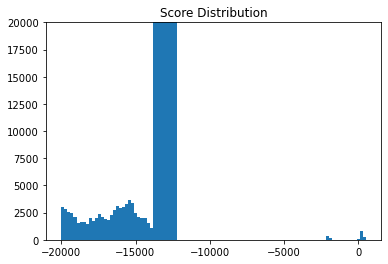

Diversity Rate: 0.05, substitutions/indel: 0.5


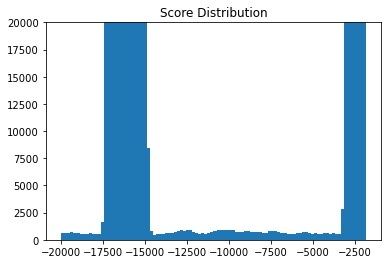

In [429]:
for d in divRates:
    for s in subIndelRats:
        print(f"Diversity Rate: {d}, substitutions/indel: {s}")
        plt.hist(scores[(d, s)], bins=100)
        plt.title("Score Distribution")
        plt.ylim(0, 20000)
        plt.show()
        break
        plt.figure()

# Benchmark on Real Data
[Back to Big Table of Contents](#Big-Table-of-Contents)

Read Length:
* Min.: 382
* Max.: 28564
* Avg.: 9147.4
* Std.: 6236.30898849632

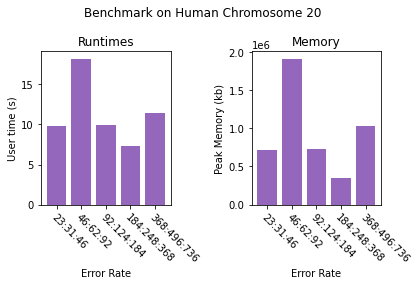

In [309]:
errorPatterns = ["23:31:46", "46:62:92", "92:124:184", "184:248:368", "368:496:736"]
benchmarksPerErrorPattern = {}

for p in errorPatterns:
    benchmarkFileNames = glob(f"../benchmarks/benchFindThoms_humanChr20_refined_onlyCapitalNucs_ep{p}_" + \
                                                       f"s1657921994_rr*_k15_c1_u1_t-1000.txt")
    benchmarksPerErrorPattern[p] = loadBenchmarks(benchmarkFileNames)

fig, axes = plt.subplots(1, 2)
BAR_WIDTH = 0.8
xcoords = range(len(errorPatterns))

for p in benchmarksPerErrorPattern:
    axes[0].bar(errorPatterns, [mean(benchmarksPerErrorPattern[p]['rt']) for p in errorPatterns])
    axes[1].bar(errorPatterns, [mean(benchmarksPerErrorPattern[p]['mem']) for p in errorPatterns])

fig.suptitle("Benchmark on Human Chromosome 20")
axes[0].set_title("Runtimes")
axes[0].set_xlabel("Error Rate")
axes[0].set_ylabel("User time (s)")
axes[0].set_xticks(axes[0].get_xticks())
axes[0].set_xticklabels(errorPatterns, rotation = -45, ha='left', rotation_mode='anchor')
axes[1].set_title("Memory")
axes[1].set_xlabel("Error Rate")
axes[1].set_ylabel("Peak Memory (kb)")
axes[1].set_xticks(axes[1].get_xticks())
axes[1].set_xticklabels(errorPatterns, rotation = -45, ha='left', rotation_mode='anchor')
plt.tight_layout()
plt.show()

# Expectation Value Estimation
[Back to Big Table of Contents](#Big-Table-of-Contents)

## Contents 4
* [Setting](#Setting)
* [Empirical Results](#Empirical-Results)

## Setting
[Back to Contents](#Contents-4)
We are calculating the global similarity between two sketches using our scoring function with unit scores. The sequences of sketches have an equal length of 10kb and one was obtained from the other using our mutation model with a substitution rate of 0.01. Neither deletion nor insertions were applied. Sequences were chosen and mutated in a way that each sketch did not contain any duplicate hash. $k=11$ was used to create the sketches which contain all $k$-mers whose hash values belong to the smallest 10% hash values of all possible $k$-mers.

According to our previous thoughts, we would a assume an expectation value of

In [334]:
0.1 * (10000 - 3 * (10000 * (1 - (1 -0.01)**11)))

686.0147627761493

## Empirical Results
[Back to Contents](#Contents-4)

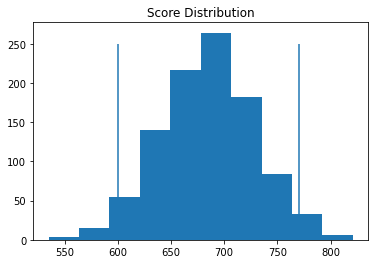

Score Avg.: 684.74, Std.: 44.01295718308417


In [346]:
scores = []

for f in glob("../simulations/expValExp/scores/nonDupGlobIntSecScore_s*_sl10000_sr0.01_ir0_dr0_k11_r0.1_c1_u1.txt"):
        scores.append(int(open(f, 'r').readline()))

In [437]:
#Plot score histogram 
def plotScoreHist(scores):
    #Find 95% confidence interval#
    #How many scores are 2.5%?
    nbOutliers = floor(len(scores) * 0.025)
    scores.sort()
    
    #Testing
    #print(nbOutliers)
    
    twoSidedBorders = (scores[nbOutliers], scores[len(scores) - 1 - nbOutliers])
    oneSidedBorder = scores[2 * nbOutliers]
    
    plt.hist(scores)
    plt.vlines(twoSidedBorders[0], 0, 250, colors = 'red')
    plt.vlines(twoSidedBorders[1], 0, 250, colors = 'red', label = "two-sided")
    plt.vlines(oneSidedBorder, 0, 250, colors = 'red', linestyles = 'dashed', label = "one-sided")
    plt.title("Score Distribution with 95% confidence interval")
    plt.legend()
    plt.show()
    print(f"Score Avg.: {mean(scores)}, Std.: {std(scores)}")
    print(f"One-sided 95% confidence interval border at {oneSidedBorder}")
    print(f"Two-sided 95% confidence interval borders at {twoSidedBorders[0]} and {twoSidedBorders[1]}")

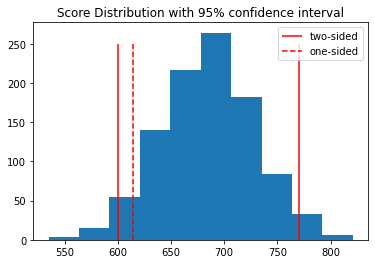

Score Avg.: 684.74, Std.: 44.01295718308417


In [350]:
plotScoreHist(scores)

In [430]:
def collectAndPlotScores(regExWthWcds):
    for d in divRates:
        for s in subIndelRats:
            scores = []
        
            print(f"Diversity Rate: {d}, substitutions/indel: {s}")

            for f in glob(regExWthWcds.replace("SUBWCD", f"{(d * s):.3f}").replace("DIVWCD", f"{d}")):
                scores.append(int(open(f, 'r').readline()))
            
            plotScoreHist(scores)

Diversity Rate: 0.01, substitutions/indel: 0.5
25


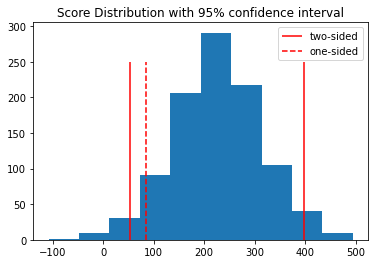

Score Avg.: 226.203, Std.: 86.45298023203132
One-sided 95% confidence interval border at 84
Two-sided 95% confidence interval borders at 53 and 398
Diversity Rate: 0.01, substitutions/indel: 1
25


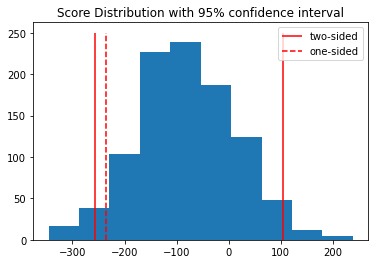

Score Avg.: -80.379, Std.: 93.97172638086415
One-sided 95% confidence interval border at -235
Two-sided 95% confidence interval borders at -256 and 104
Diversity Rate: 0.01, substitutions/indel: 2
25


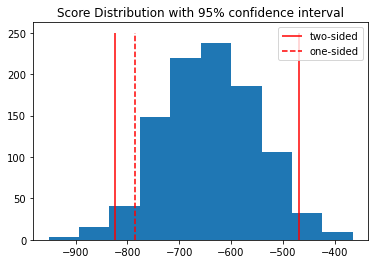

Score Avg.: -639.802, Std.: 90.9493309266209
One-sided 95% confidence interval border at -786
Two-sided 95% confidence interval borders at -824 and -469
Diversity Rate: 0.05, substitutions/indel: 0.5
25


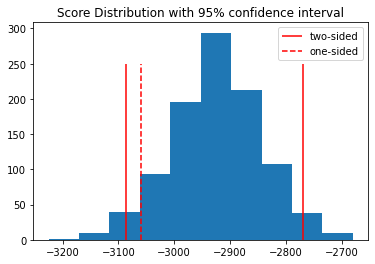

Score Avg.: -2922.913, Std.: 80.41991936703245
One-sided 95% confidence interval border at -3060
Two-sided 95% confidence interval borders at -3086 and -2769
Diversity Rate: 0.05, substitutions/indel: 1
25


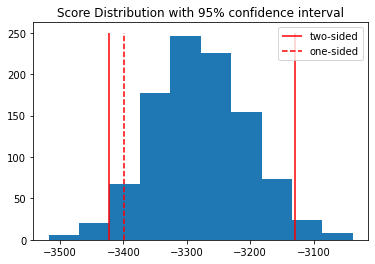

Score Avg.: -3279.495, Std.: 75.191275923474
One-sided 95% confidence interval border at -3399
Two-sided 95% confidence interval borders at -3423 and -3130
Diversity Rate: 0.05, substitutions/indel: 2
25


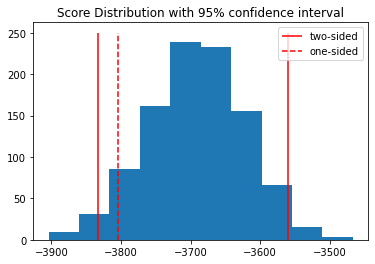

Score Avg.: -3691.567, Std.: 68.74239965988967
One-sided 95% confidence interval border at -3804
Two-sided 95% confidence interval borders at -3833 and -3560


In [436]:
collectAndPlotScores("../simulations/expValExp/scores/noDupGlobIntSecScore_se*_sl20000_srSUBWCD_irDIVWCD" + \
                     "_drDIVWCD_k15_r0.1_c1_u1.txt")

In [438]:
oSidConfBord = {(0.05, 2): -3804, (0.05, 1): -3399, (0.05, 0.5): -3060, (0.01, 2): -786, (0.01, 1): -235, \
                (0.01, 0.5): 84}

Diversity Rate: 0.01, substitutions/indel: 0.5


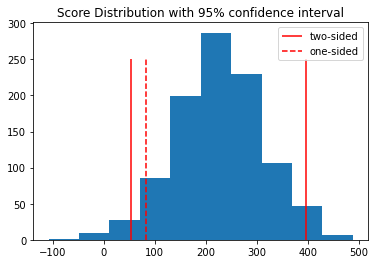

Score Avg.: 226.063, Std.: 86.07483390050776
One-sided 95% confidence interval border at 83
Two-sided 95% confidence interval borders at 53 and 396
Diversity Rate: 0.01, substitutions/indel: 1


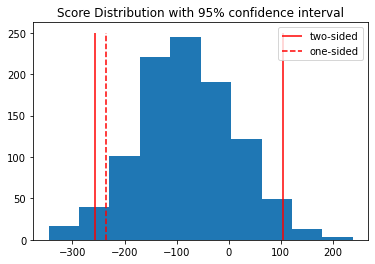

Score Avg.: -80.038, Std.: 93.33244106954453
One-sided 95% confidence interval border at -236
Two-sided 95% confidence interval borders at -256 and 104
Diversity Rate: 0.01, substitutions/indel: 2


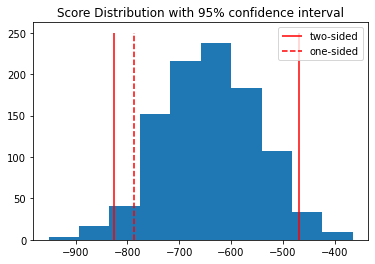

Score Avg.: -640.416, Std.: 91.57674892678818
One-sided 95% confidence interval border at -787
Two-sided 95% confidence interval borders at -826 and -469
Diversity Rate: 0.05, substitutions/indel: 0.5


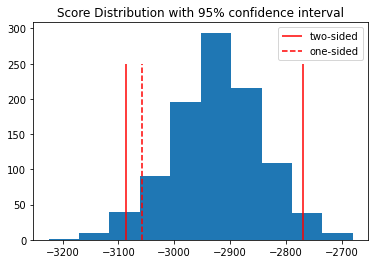

Score Avg.: -2922.013, Std.: 80.0948115111085
One-sided 95% confidence interval border at -3057
Two-sided 95% confidence interval borders at -3086 and -2769
Diversity Rate: 0.05, substitutions/indel: 1


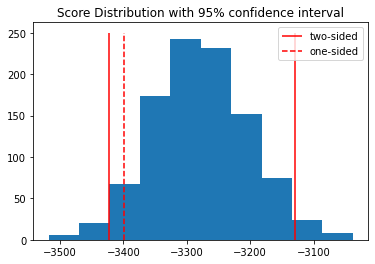

Score Avg.: -3278.896, Std.: 75.15675075467273
One-sided 95% confidence interval border at -3399
Two-sided 95% confidence interval borders at -3423 and -3130
Diversity Rate: 0.05, substitutions/indel: 2


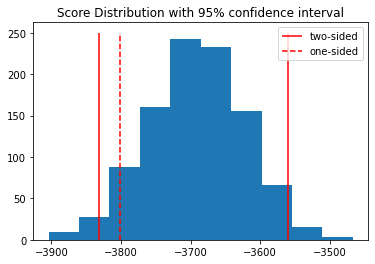

Score Avg.: -3691.291, Std.: 68.20055952116522
One-sided 95% confidence interval border at -3802
Two-sided 95% confidence interval borders at -3832 and -3560


In [444]:
collectAndPlotScores("../simulations/expValExp/scores/dupGlobIntSecScore_s*_sl20000_srSUBWCD_irDIVWCD_drDIVWCD" + \
                     "_k15_r0.1_c1_u1.txt")

# Testing
[Back to Big Table of Contents](#Big-Table-of-Contents)

## Contents 5
* [Useful Functions](#Useful-Functions)
* [Miscellaneous](#Miscellaneous)

## Useful Functions
[Back to Contents](#Contents-5)

In [445]:
def readFasta(path):
    return [r for r in SeqIO.parse(open(path, 'r'), "fasta")]

## Miscellaneous

In [462]:
seq = readFasta("../simulations/reads/reads_tl50000_rid0_chP6C4_ep0:0:0_0.fasta")[0]
indexSeq = [int(n) for n in open("src/indexSeq.tmp", 'r').readline().split(' ')[:-1]]
baseNumberMapping = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}

for i in range(len(seq.seq)):
    if baseNumberMapping[indexSeq[i]] != seq.seq[i]:
        print("Bases are different")

In [280]:
print(len(firstRead.seq))

9943


In [469]:
bitRepSeqList = [1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
intRep = 0

for i in range(len(bitRepSeqList)):
    intRep += bitRepSeqList[i] * (2 ** (len(bitRepSeqList) - 1 - i))
    
print(intRep)
print(2**64)

936235520
18446744073709551616


In [483]:
p = 4716
p1 = 19128
k = 15

print(f"{k}-mer sequence at index position {p}:", seq.seq[p - k + 1: p + 1].reverse_complement())
print(f"{k}-mer sequence at index position {p1}:", seq.seq[p1 - k + 1: p1 + 1])

for i in range(3):
    revSeq = seq.seq[p1 - 1: p1 + k + 2][i:i+k].reverse_complement()
    print(seq.seq.find(revSeq))

15-mer sequence at index position 4716: AAATACACCGCACTG
15-mer sequence at index position 19128: AAATACACCGCACTG
-1
-1
-1


In [278]:
from Bio.Seq import Seq

for p in otherPos:
    els = [e for e in lines[p * 4 + 1].strip().split(' ') if e != ""]
    nels = [e for e in lines[p * 4 + 2].strip().split(' ') if e != ""]
    
    #print(els[6][:10])
    readSeq = Seq(nels[6].replace('-', "")).reverse_complement()
    #print(genome[0].seq[int(els[2]):int(els[2]) + int(els[3])])
    print(els[6].replace('-', "") == genome[0].seq[int(els[2]):int(els[2]) + int(els[3])])
    #mpg = genome[0].seq[int(els[2]):int(els[2]) + int(els[3])]
    #
    #if nels[4] == '+':
    #    mpm = els[6].replace('-', "")
    #else:
    #    mpm = 

True
True


In [281]:
read = [r for r in SeqIO.parse(open("../simulations/reads/SAL_GB9998AA_AS_cR103_ep23:31:46_0001.fastq", 'r'), \
                               "fastq") if r.id == "S1_1532"][0].seq
read == readSeq

True

In [298]:
b["1"] = 0

NameError: name 'b' is not defined